# Final project: Identification of vulnerable population groups

## 1. Problem statement

According to a December 2021 [inFOM survey](https://www.cbr.ru/Collection/Collection/File/39633/inFOM_21-12.pdf), 27% of Russians have enough money only for food, and another 9% cannot afford a nutritious diet. These people are especially attentive to prices, and the rate of growth of food prices usually exceeds the average rate of inflation. At the same time, Rosstat believes that food expenses should make up approximately 36% of a Russian's average monthly expenses (another 10% goes to utilities and housing, 4% goes to medicines). 

Until 2021, the "poverty line" (living below the subsistence minimum) in Russia was determined by the cost of the [minimum food basket](https://base.garant.ru/70306880/). In the same year, the government "untied" the poverty level from the prices of basic products: since 2021, the subsistence minimum is calculated as 44.2% of the median income of Russian citizens for the previous year.

You have at your disposal data on income, morbidity, socially vulnerable groups of the Russian population and other economic and demographic data.

Your task as a data scientist:
* cluster the regions of Russia and determine which of them are in the greatest need of assistance to low-income/disadvantaged segments of the population;
* describe the population groups facing poverty;
* determine:
    * whether the number of children, pensioners and other socially vulnerable groups affects the poverty level in the region;
    * whether the level of poverty/social disadvantage is related to production and consumption in the region;
    * what other dependencies can be observed in relation to socially vulnerable segments of the population.

### 1.0 Import dependencies and define helper code

#### 1.0.1 Import dependencies

In [1120]:

import pandas as pd
import plotly.express as px

from scipy import stats
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#### 1.0.2 Define helper code

In [1133]:
regions_count = 85


def drop_empty_years(df):
    missing = df.isnull().sum()
    missing_columns = missing[missing > regions_count * 0.4].index
    df = df.drop(missing_columns, axis=1)
    return df


def normalize_data(df):
    return df.apply(
        stats.zscore, 
        axis=1, 
        nan_policy='omit'
    )


def rename_columns(df, prefix, start_col=1):
    dict_columns = {}
    for i in range(start_col, df.shape[1]):
        dict_columns[df.columns[i]] = prefix + str(df.columns[i])

    return df.rename(columns=dict_columns)

## 2. Getting to know the data

To reduce data redundancy, data for districts uniting multiple regions has been removed from the initial data sources. Also the following former regions have been removed, since they have significant amount of empty values: 
* Агинский Бурятский округ (Забайкальский край)
* Коми-Пермяцкий округ, входящий в состав Пермского края
* Корякский округ, входящий в состав Камчатского края
* Таймырский (Долгано-Ненецкий) автономный округ (Красноярский край)
* Усть-Ордынский Бурятский округ
* Эвенкийский автономный округ (Красноярский край)

The source .xlsx and .csv files have been checked to not have any duplicates in data.

### 2.1 Population data

Data source contains the population dynamics of the Russian regions across the years 1999 and 2022. Columns:
1. `region` - name of the region of the Russian Federation. 
2. `population_1999-population_2022` - columns containing the population count for each of the regions in the corresponding year.

In [1122]:
data_population = pd.read_excel('data/population.xlsx', 'report')
for i in range(data_population.shape[0]//2):
    data_population.iloc[i, 1:] = data_population.iloc[i+1, 1:]
    data_population.drop(index=i+1, inplace=True)
    data_population = data_population.reset_index(drop=True)

data_population = data_population.set_index('region')
data_population = data_population.sort_index()

Let's visualize the population dynamics in different regions. We'll normalize data in each of the regions separately to get the dynamics within the region.

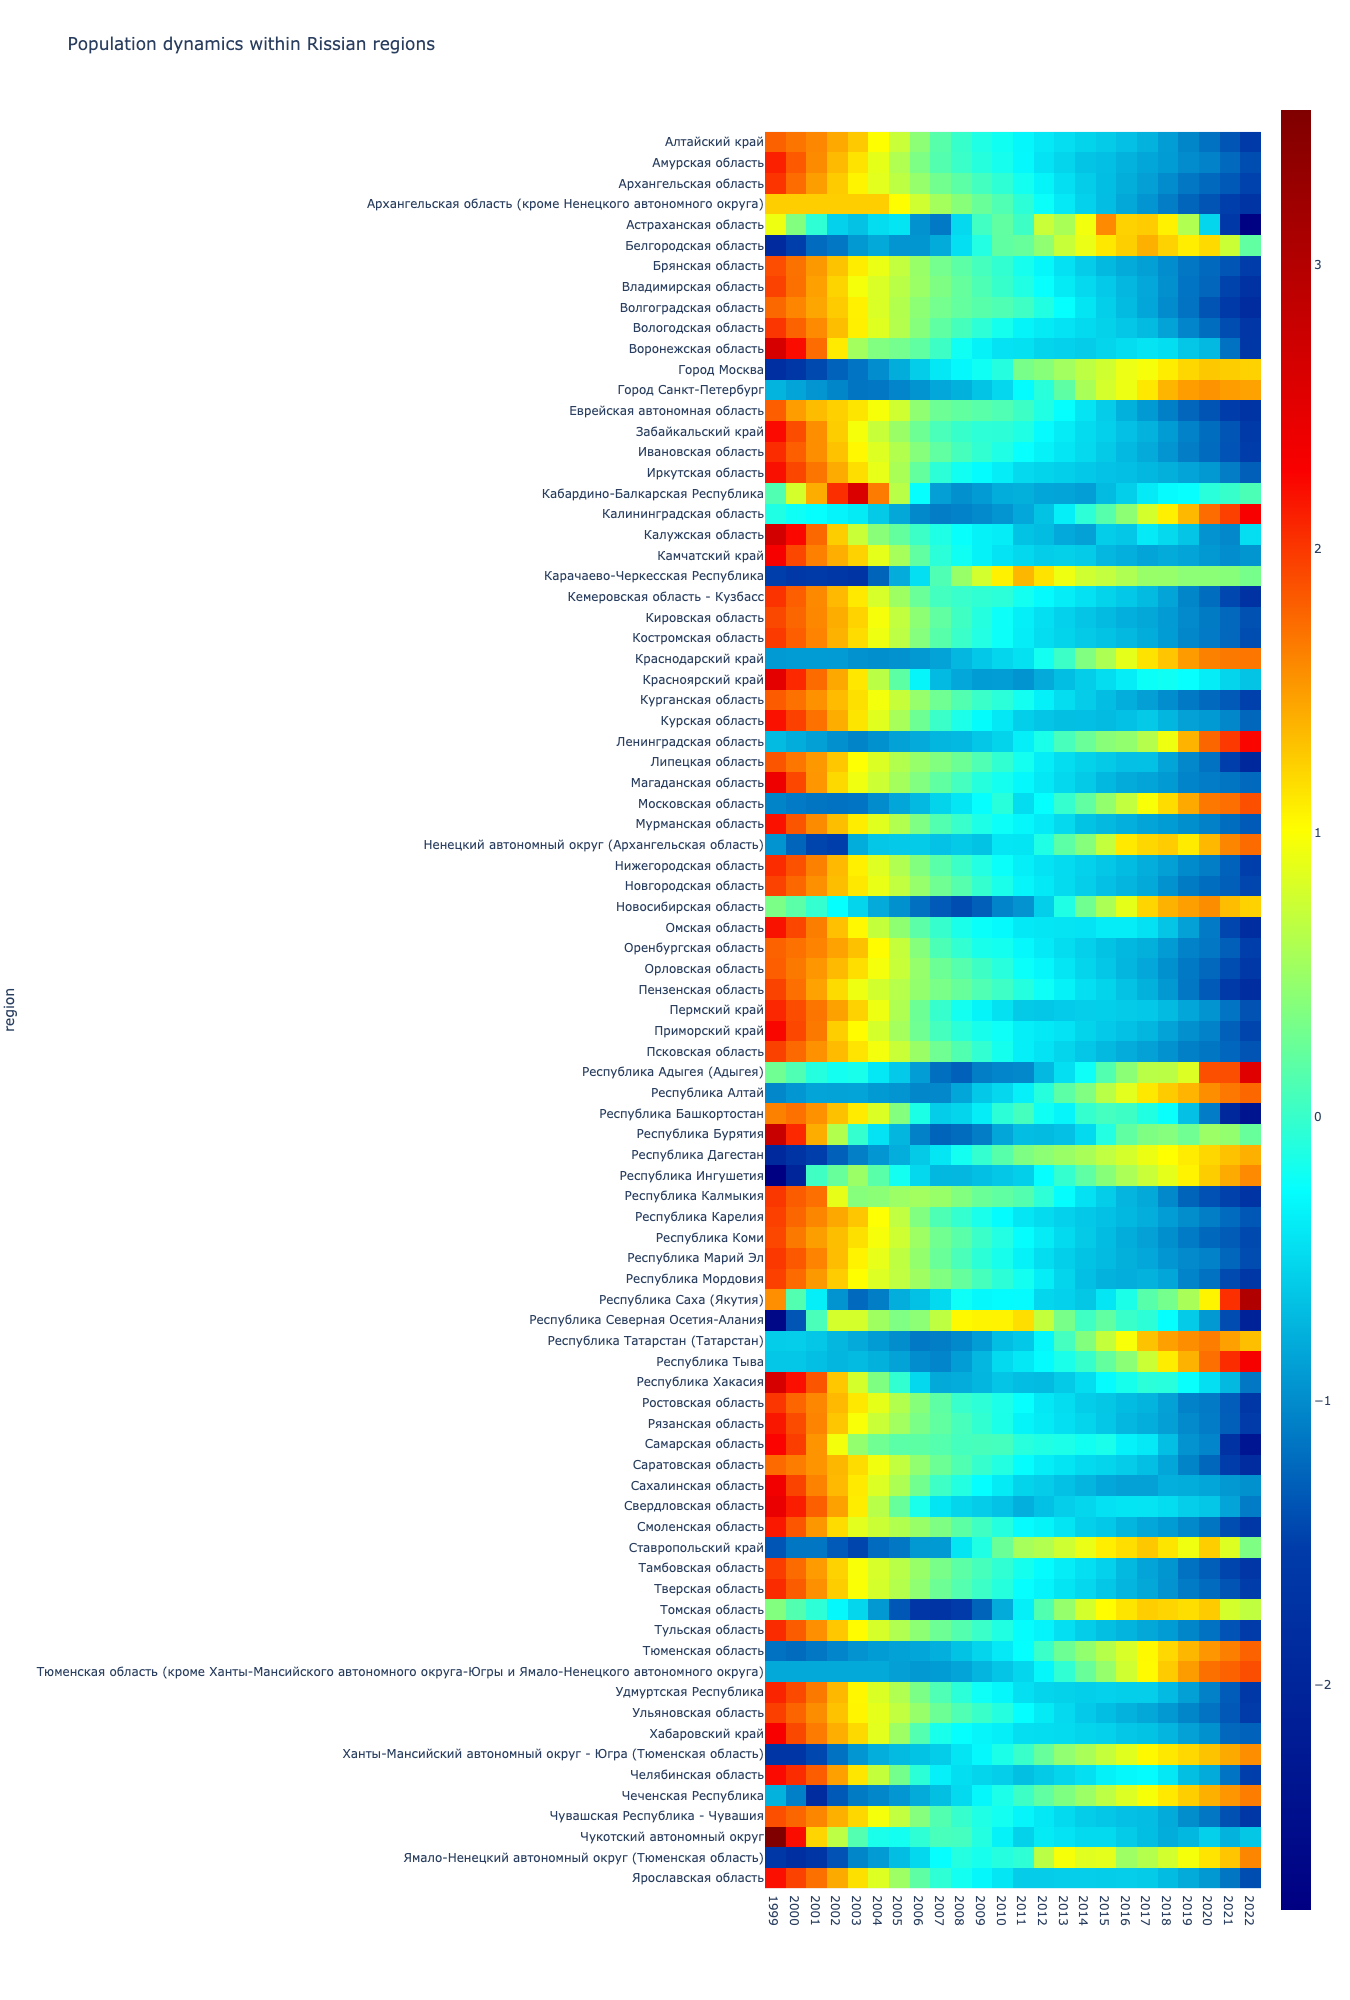

In [1134]:
data_population = data_population.interpolate(axis=1, limit_direction='both')

data_population_normalized = normalize_data(data_population)

fig = px.imshow(
    data_population_normalized,
    height=2000,
    width=1350,
    color_continuous_scale='Jet',
    title='Population dynamics within Rissian regions'
)
fig.show('png')

We observe that there are more regions with the population decline than regions with the population growth. If we connect population decline with the economic situation of the region, we will probably observe a larger amount of the regions in the cluster with economic issues.

A few regions which demonstrated a population growth are as follows:
- Город Москва
- Город Санкт-Петербург
- Калининградская область
- Краснодарский край
- Ленинградская область
- Московская область
- Ненецкий автономный округ (Архангельская область)
- Новосибирская область
- Республика Адыгея (Адыгея)
- Республика Алтай
- Республика Дагестан
- Республика Ингушетия
- Республика Саха (Якутия)
- Республика Татарстан (Татарстан)
- Республика Тыва
- Тюменская область
- Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)
- Ханты-Мансийский автономный округ - Югра (Тюменская область)
- Чеченская Республика
- Ямало-Ненецкий автономный округ (Тюменская область)

### 2.2 Child mortality in rural areas

Data source contains child mortality in rural areas on the first life year in persons per Russian region across the years 1990 and 2021 in absolute values. Columns:
1. `region` - name of the region of the Russian Federation. Data for districts uniting multiple regions has been removed.
2. `child_mortality_rural_1990-child_mortality_rural_2021` - columns containing the child mortality in rural areas for each of the regions in the corresponding year.

In [1124]:
data_child_mortality_rural = pd.read_excel('data/child_mortality_rural_1990_2021.xlsx')
data_child_mortality_rural['region'] = data_child_mortality_rural['region'].str.strip()
data_child_mortality_rural = data_child_mortality_rural.set_index('region', drop=True)
data_child_mortality_rural = data_child_mortality_rural.sort_index()

Let's visualize the child mortality in rural areas dynamics in different regions. We'll normalize data in each of the regions separately to get the dynamics within the region.

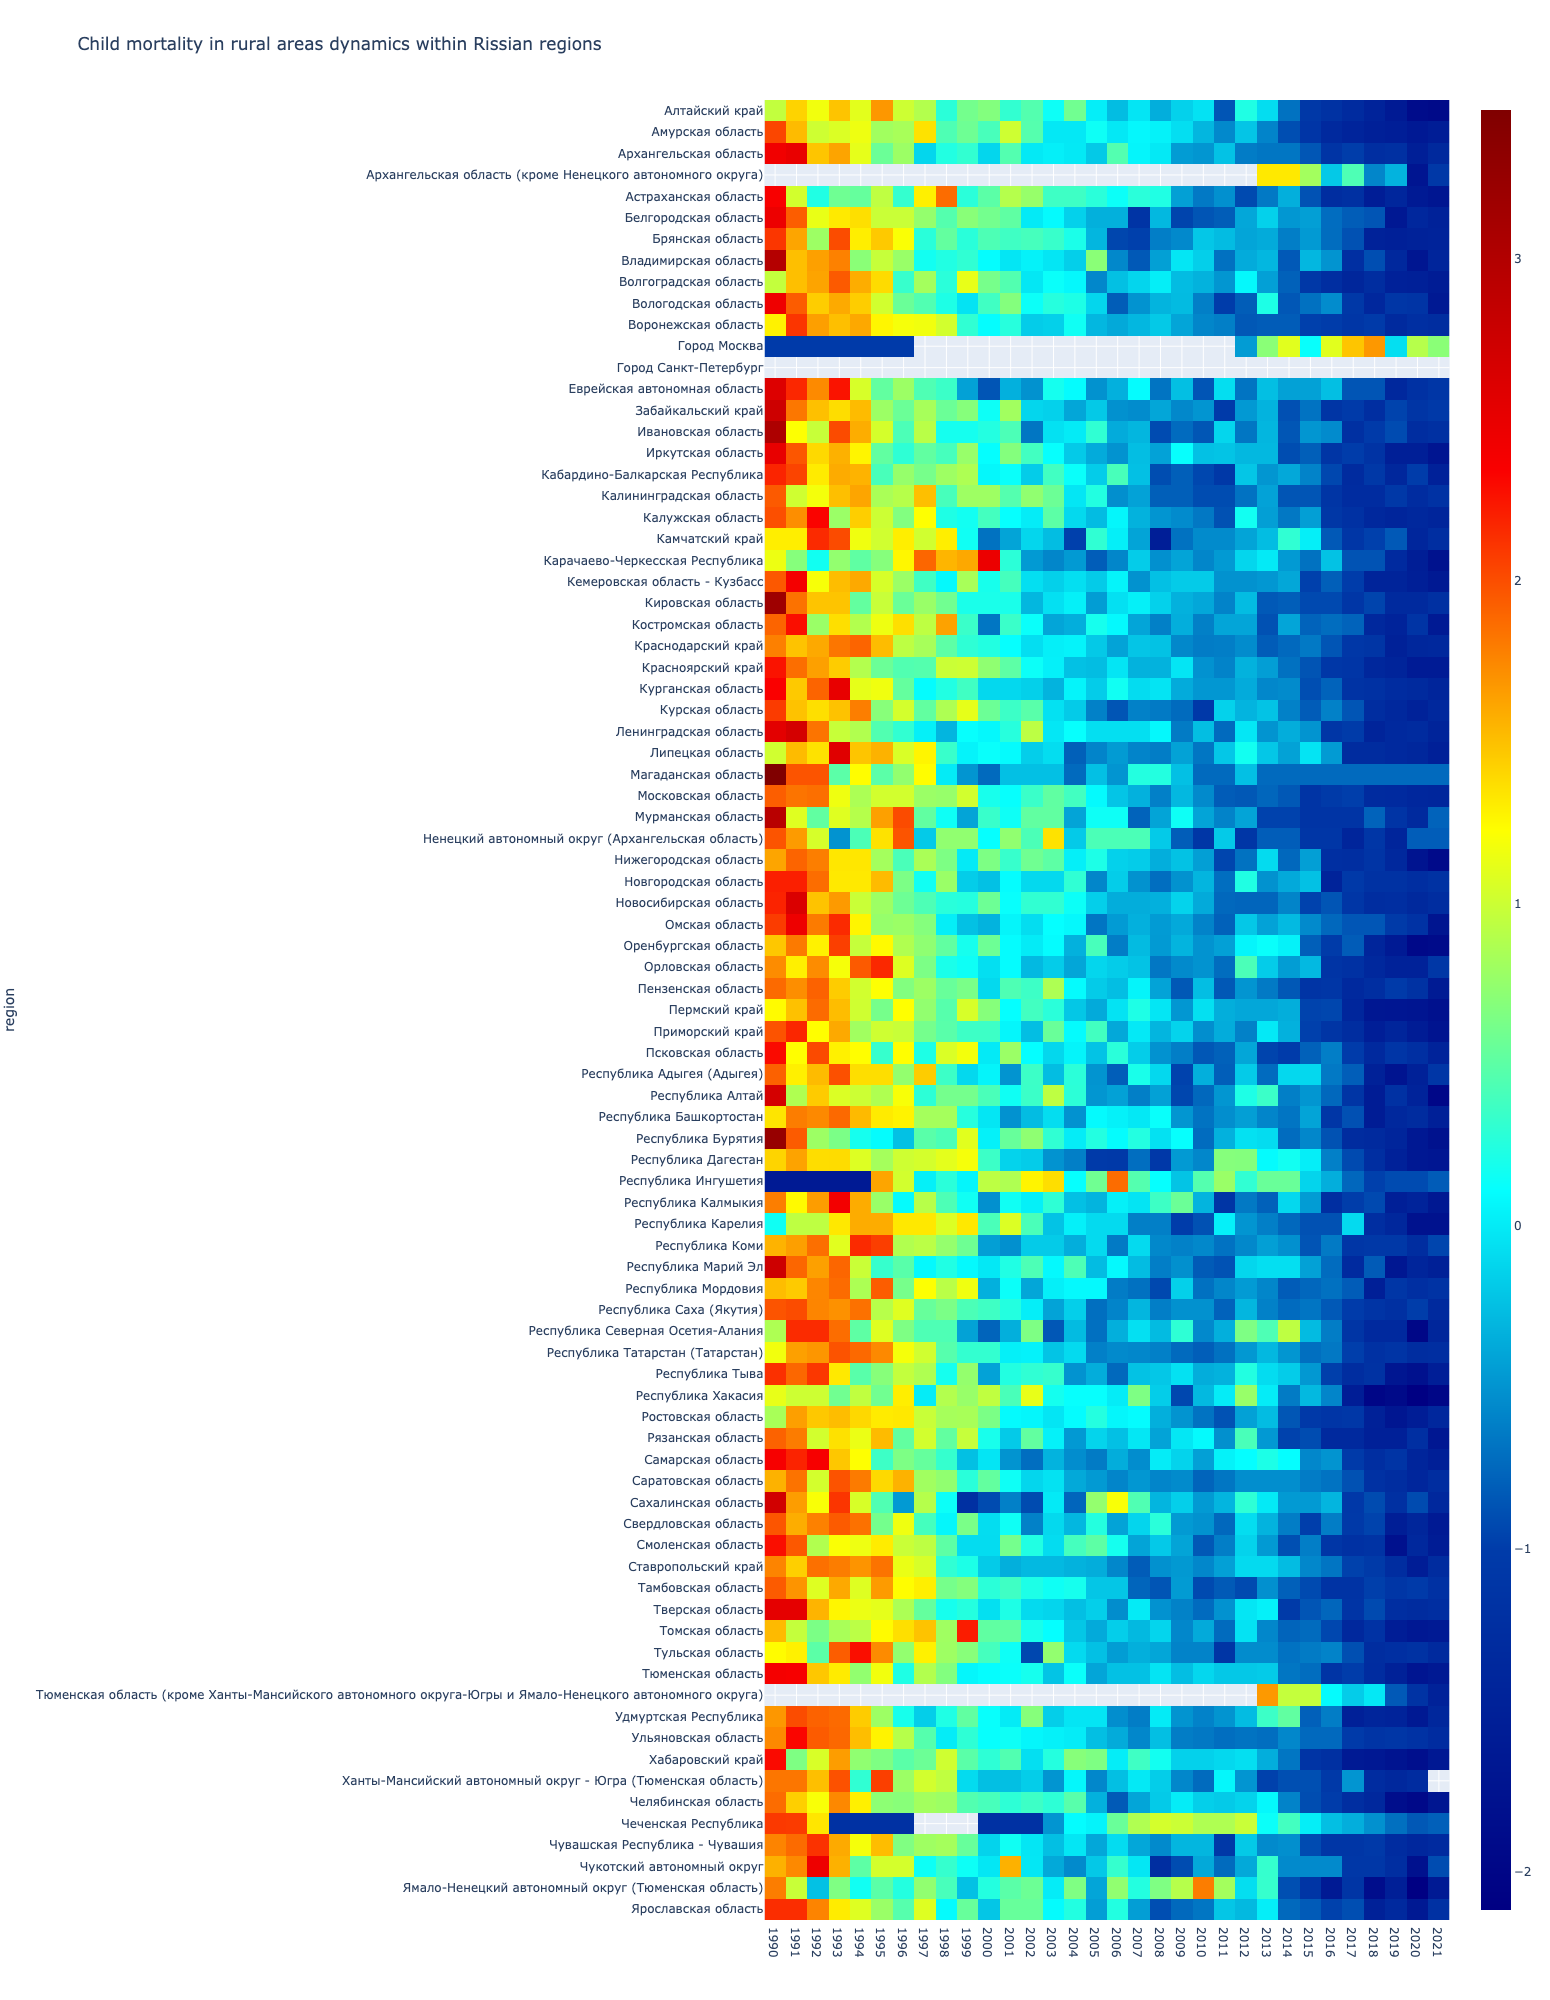

In [1125]:
data_child_mortality_rural_normalized = normalize_data(data_child_mortality_rural)

fig = px.imshow(
    data_child_mortality_rural_normalized,
    height=2000,
    width=1550,
    color_continuous_scale='Jet',
    title='Child mortality in rural areas dynamics within Rissian regions'
)
fig.show('png')

Child mortality in rural areas has significantly decreased with the exception of the following regions:
- Город Москва
- Магаданская область
- Республика Ингушетия
- Чеченская Республика

If we connect the child mortality with the economic situation of the region, we cann assume that after applying the cluster algorithms these regions might be in the cluster of economically weaker regions. Which is definitely not the case for the city of Moscow.

### 2.3 Child mortality in urban areas

Data source contains child mortality in urban areas on the first life year in persons per Russian region across the years 1990 and 2021 in absolute values. Columns:
1. `region` - name of the region of the Russian Federation. Data for districts uniting multiple regions has been removed.
2. `child_mortality_urban_1990-child_mortality_urban_2021` - columns containing the child mortality in urban areas for each of the regions in the corresponding year.

In [1126]:
data_child_mortality_urban = pd.read_excel('data/child_mortality_urban_1990_2021.xlsx')
data_child_mortality_urban['region'] = data_child_mortality_urban['region'].str.strip()
data_child_mortality_urban = data_child_mortality_urban.set_index('region', drop=True)
data_child_mortality_urban = data_child_mortality_urban.sort_index()

Let's visualize the child mortality in urban areas dynamics in different regions. We'll normalize data in each of the regions separately to get the dynamics within the region.

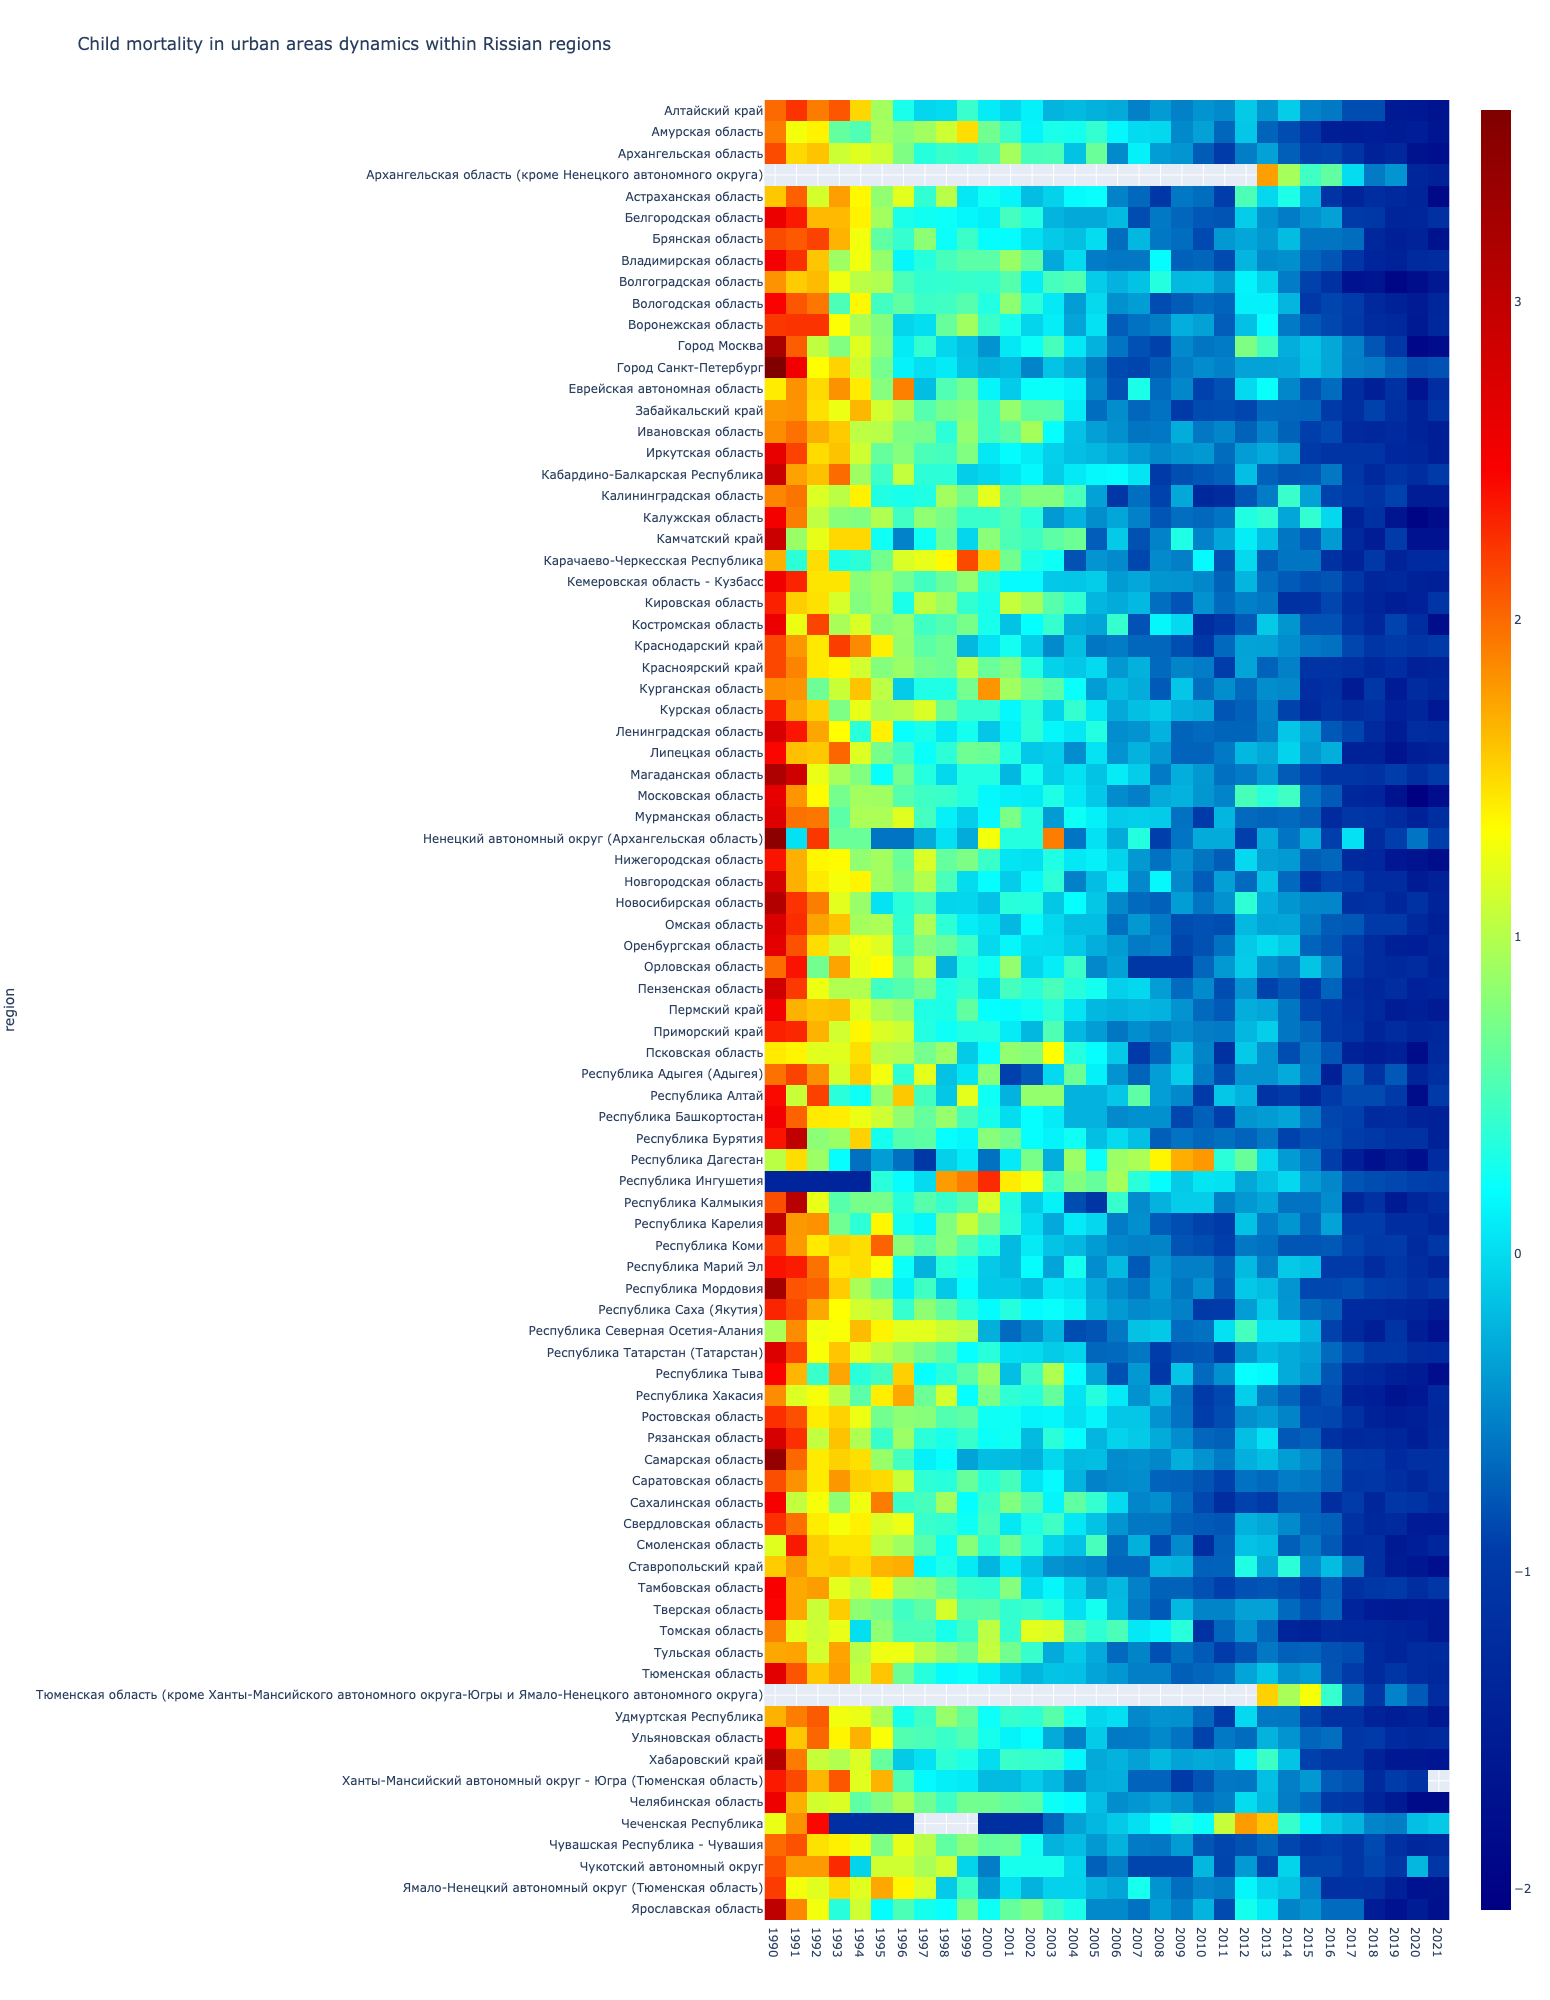

In [1127]:
data_child_mortality_urban_normalized = normalize_data(data_child_mortality_urban)

fig = px.imshow(
    data_child_mortality_urban_normalized,
    height=2000,
    width=1550,
    color_continuous_scale='Jet',
    title='Child mortality in urban areas dynamics within Rissian regions'
)
fig.show('png')

Child mortality in urban areas has significantly decreased with the exception of the following regions:
- Город Санкт-Петербург
- Республика Ингушетия
- Чеченская Республика

If we connect the child mortality with the economic situation of the region, we cann assume that after applying the cluster algorithms these regions might be in the cluster of economically weaker regions. Which is definitely not the case for the city of Saint Petersburg.

### 2.4 Disability statistics

Data source is loaded and then gets transformed to contain the disability data per Russion region across the years 2017 and 2022 in absolute values. Columns
1. `region` - name of the region of the Russian Federation. Data for districts uniting multiple regions has been removed.
2. `disability_{year}_total, disability_{year}_18_30, disability_{year}_31_40, disability_{year}_41_50, disability_{year}_60_` - columns containing the disability counts across the whole population and across different age groups for each of the regions in the corresponding year.

In [1128]:
data_disability = pd.read_csv('data/disabled_total_by_age_2017_2022.csv', sep=';')
data_disability = data_disability[data_disability['date'].str.endswith('01-01')]


def flatten_table(df, years):
    result = []
    for year in years:
        df_year = df[df['date'].str.startswith(year)]
        df_year = df_year.drop(columns='date')
        df_year = rename_columns(df_year, f'disability_{year}_')
        df_year = df_year.set_index('region')
        result.append(df_year)
    return pd.concat(result, axis=1)


data_disability = flatten_table(data_disability, ['2017', '2018', '2019', '2020', '2021', '2022'])

Let's visualize the total dysability dynamics in different regions. We'll normalize data in each of the regions separately to get the dynamics within the region.

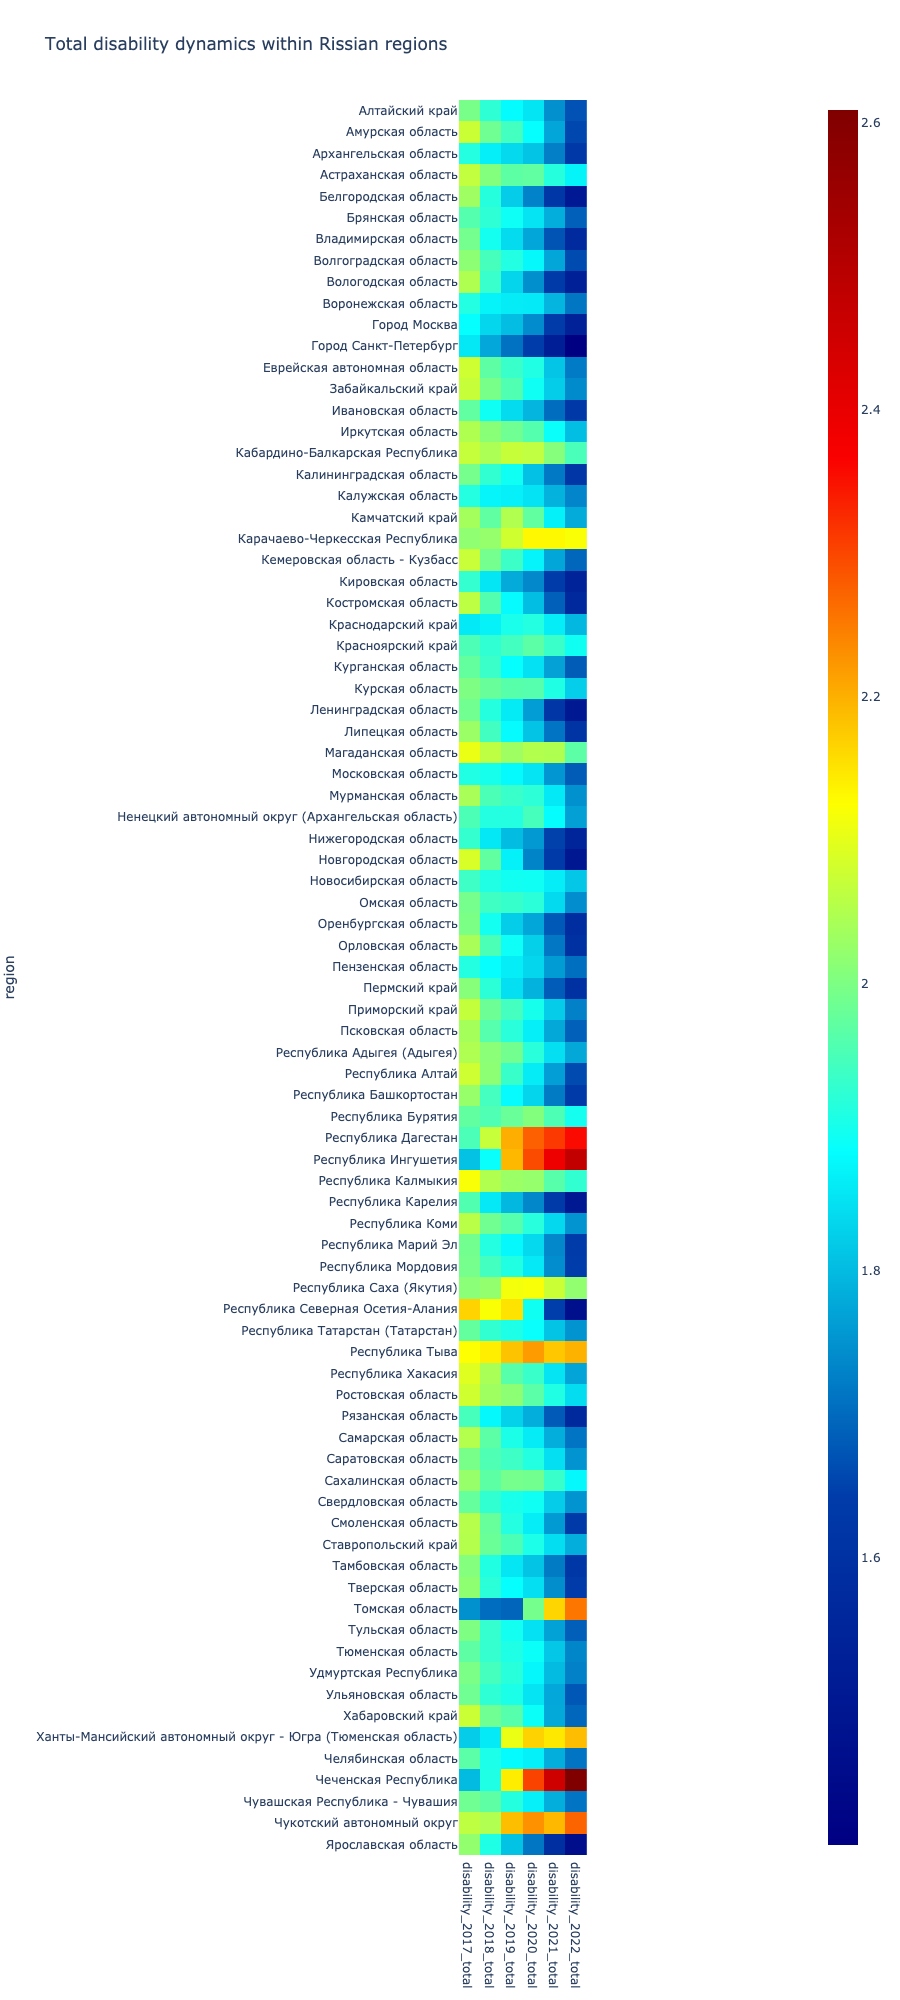

In [1129]:
# Delete the years which have up to 40 % of empty values.
data_disability = drop_empty_years(data_disability)

data_disability_normalized = normalize_data(data_disability)

fig = px.imshow(
    data_disability_normalized.filter(regex='total$', axis=1),
    height=2000,
    width=900,
    color_continuous_scale='Jet',
    title='Total disability dynamics within Rissian regions'
)
fig.show('png')

Total disability has decreased with the exception of the following regions:
- Карачаево-Черкесская Республика
- Республика Дагестан
- Республика Ингушетия
- Республика Тыва
- Томская область
- Ханты-Мансийский автономный округ - Югра (Тюменская область)
- Чеченская Республика
- Чукотский автономный округ

Growing disability rate means that a portion of socially incecure population is growing in the region. Let's check after the applying the cluster algorithms if any of these regions will end-up in an economically weak cluster.

### 2.5 Desease Incidence Statistics

Data source is loaded and then gets transformed to contain the desease incidence (per 100000 people in the corresponding age group) data per Russion region across the years 2005 and 2016. Data has been reduced for total deseases per region and age group, specific desease statistics have been removed. Columns
1. `region` - name of the region of the Russian Federation. Data for districts uniting multiple regions has been removed.
2. `desease_incidence_0-14 years_{year}, desease_incidence_15-17 years_{year}, desease_incidence_18 years and older_{year}, desease_incidence_Total_{year}` - columns containing the desease incidence across the whole population and across different age groups for each of the regions in the corresponding year.

In [1130]:
data_desease_incidence = pd.read_excel(
    'data/morbidity_2005_2016_age_disease.xlsx',
    index_col=[0, 1]
)
data_desease_incidence_list = []
age_groups = ['0-14 years', '15-17 years', '18 years and older', 'Total']
for age_group in age_groups:
    df = data_desease_incidence[data_desease_incidence.index.get_level_values('age_group') == age_group]
    df = df.reset_index()
    df = df.drop('age_group', axis=1)
    df = rename_columns(df, f'desease_incidence_{age_group}_')
    df['region'] = df['region'].str.strip()
    df = df.set_index('region')
    data_desease_incidence_list.append(df)
data_desease_incidence = pd.concat(data_desease_incidence_list, axis=1)
data_desease_incidence = data_desease_incidence.sort_index()

Let's visualize the total desease incidence dynamics in different regions. We'll normalize data in each of the regions separately to get the dynamics within the region.

In [1132]:
# Delete the years which have up to 40 % of empty values.
#data_desease_incidence = drop_empty_years(data_desease_incidence)

missing = data_desease_incidence.isnull().sum()
missing > regions_count * 0.6
#missing_columns = missing[missing > regions_count * 0.6].index
# #    missing_columns = missing[missing > 0].index
# df = df.drop(missing_columns, axis=1)
# return df.dropna()

# data_desease_incidence_normalized = normalize_data(data_desease_incidence)

# fig = px.imshow(
#     data_desease_incidence_normalized.filter(like='Total', axis=1),
#     height=1900,
#     width=740,
#     color_continuous_scale='Jet',
#     title='Total desease incidence dynamics within Rissian regions'
# )
# fig.show('png')

desease_incidence_0-14 years_2005            False
desease_incidence_0-14 years_2006            False
desease_incidence_0-14 years_2007            False
desease_incidence_0-14 years_2008            False
desease_incidence_0-14 years_2009            False
desease_incidence_0-14 years_2010            False
desease_incidence_0-14 years_2011            False
desease_incidence_0-14 years_2012            False
desease_incidence_0-14 years_2013            False
desease_incidence_0-14 years_2014            False
desease_incidence_0-14 years_2015            False
desease_incidence_0-14 years_2016            False
desease_incidence_15-17 years_2005           False
desease_incidence_15-17 years_2006           False
desease_incidence_15-17 years_2007           False
desease_incidence_15-17 years_2008           False
desease_incidence_15-17 years_2009           False
desease_incidence_15-17 years_2010           False
desease_incidence_15-17 years_2011           False
desease_incidence_15-17 years_2

Multiple regions show an increase in desease incidence with some regions showing significant growth:
- Карачаево-Черкесская Республика
- Республика Ингушетия
- Чеченская Республика

High desease incidence values could mean that a portion of socially incecure population is growing in the region. Let's check after the applying the cluster algorithms if any of these regions will end-up in an economically weak cluster.

### 2.6 Welfare Expense Share

Data source is loaded and then gets transformed to contain the welfare expense data per Russion region across the years 2015 and 2020. Columns
1. `region` - name of the region of the Russian Federation. Data for districts uniting multiple regions has been removed.
2. `welfare_share_2015-welfare_share_2020` - columns containing the welfare expense percentage across the whole population for each of the regions in the corresponding year.

In [ ]:
data_welfare_share = pd.read_excel('data/welfare_expense_share_2015_2020.xlsx')
data_welfare_share = data_welfare_share.set_index('region', drop=True)
data_welfare_share = data_welfare_share.sort_index()

Let's visualize the welfare expense share dynamics in different regions. We'll normalize data in each of the regions separately to get the dynamics within the region.

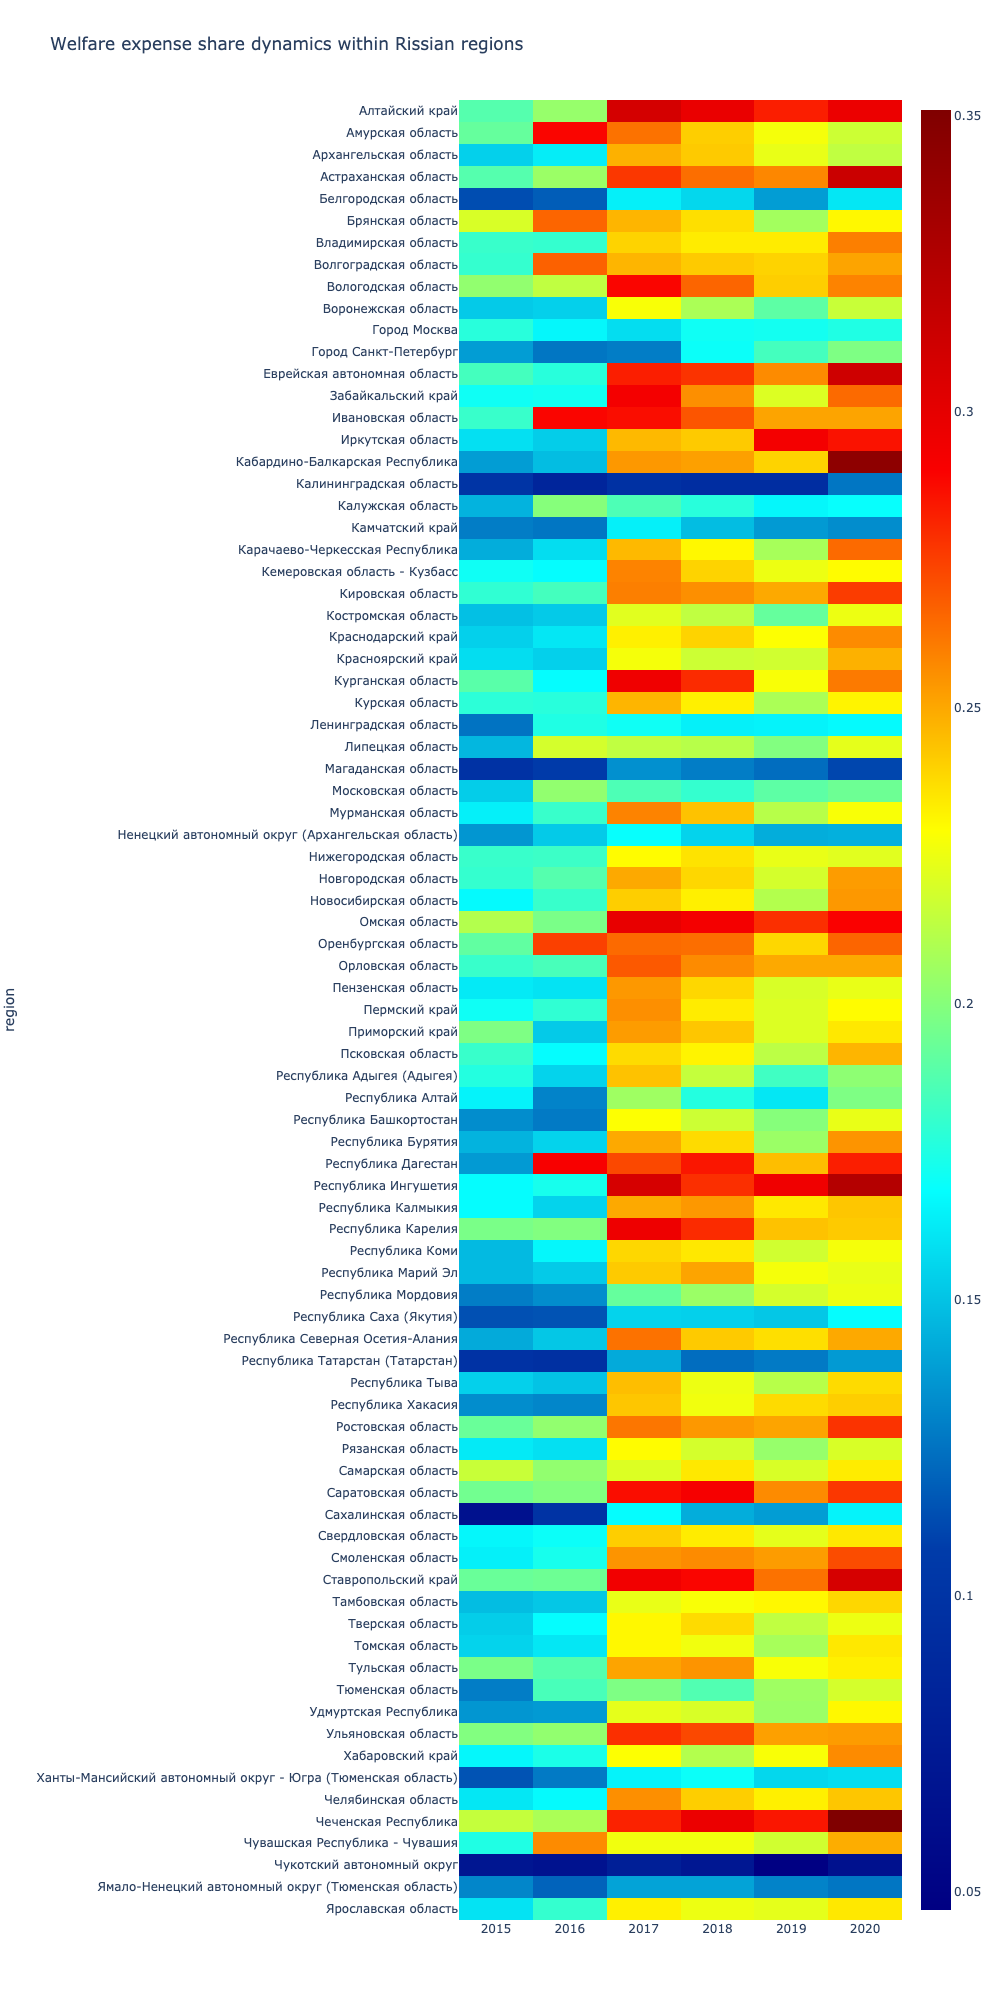

In [ ]:
# Delete the years which have up to 40 % of empty values.
data_welfare_share = drop_empty_years(data_welfare_share)

data_welfare_share_normalized = data_welfare_share / 100

fig = px.imshow(
    data_welfare_share_normalized,
    height=2000,
    width=1000,
    color_continuous_scale='Jet',
    title='Welfare expense share dynamics within Rissian regions'
)
fig.show('png')

There is a trend of a high or growing welfare expense share across the regions. Only the following regions do not follow this trend:
- Калининградская область
- Камчатский край
- Магаданская область
- Ненецкий автономный округ (Архангельская область)
- Республика Татарстан (Татарстан)
- Чукотский автономный округ
- Ямало-Ненецкий автономный округ (Тюменская область)

Growing welfare expense share might be interpreted as the region is economically strong to support poor people. If this share is not growing in a region, then it could be economically not doing well to an extent that there is no budget to support the socially weak groups of people. Let's see where the highlighted regions end-up after we apply the cluster algorithms.

### 2.7 Poverty Statistics

Data source is loaded and then gets transformed to contain the poverty data per Russion region across the years 1992 and 2020. Columns
1. `region` - name of the region of the Russian Federation. Data for districts uniting multiple regions has been removed.
2. `poverty_1992-poverty_2020` - columns containing the poverty percentage across the whole population for each of the regions in the corresponding year.

In [ ]:
data_poverty = pd.read_csv(
    'data/poverty_percent_by_regions_1992_2020.csv', 
    sep=';', 
    skipinitialspace=True
)


def flatten_table(df, years):
    result = []
    for year in years:
        df_year = df[df['year'] == year]
        df_year = df_year.drop(columns='year')
        df_year = rename_columns(df_year, f'poverty_{year}_')
        df_year = df_year.set_index('region')
        result.append(df_year)
    return pd.concat(result, axis=1)


data_poverty = flatten_table(data_poverty, list(range(1992, 2021)))
data_poverty = data_poverty.sort_index()

Let's visualize the poverty rate dynamics in different regions. We'll normalize data in each of the regions separately to get the dynamics within the region.

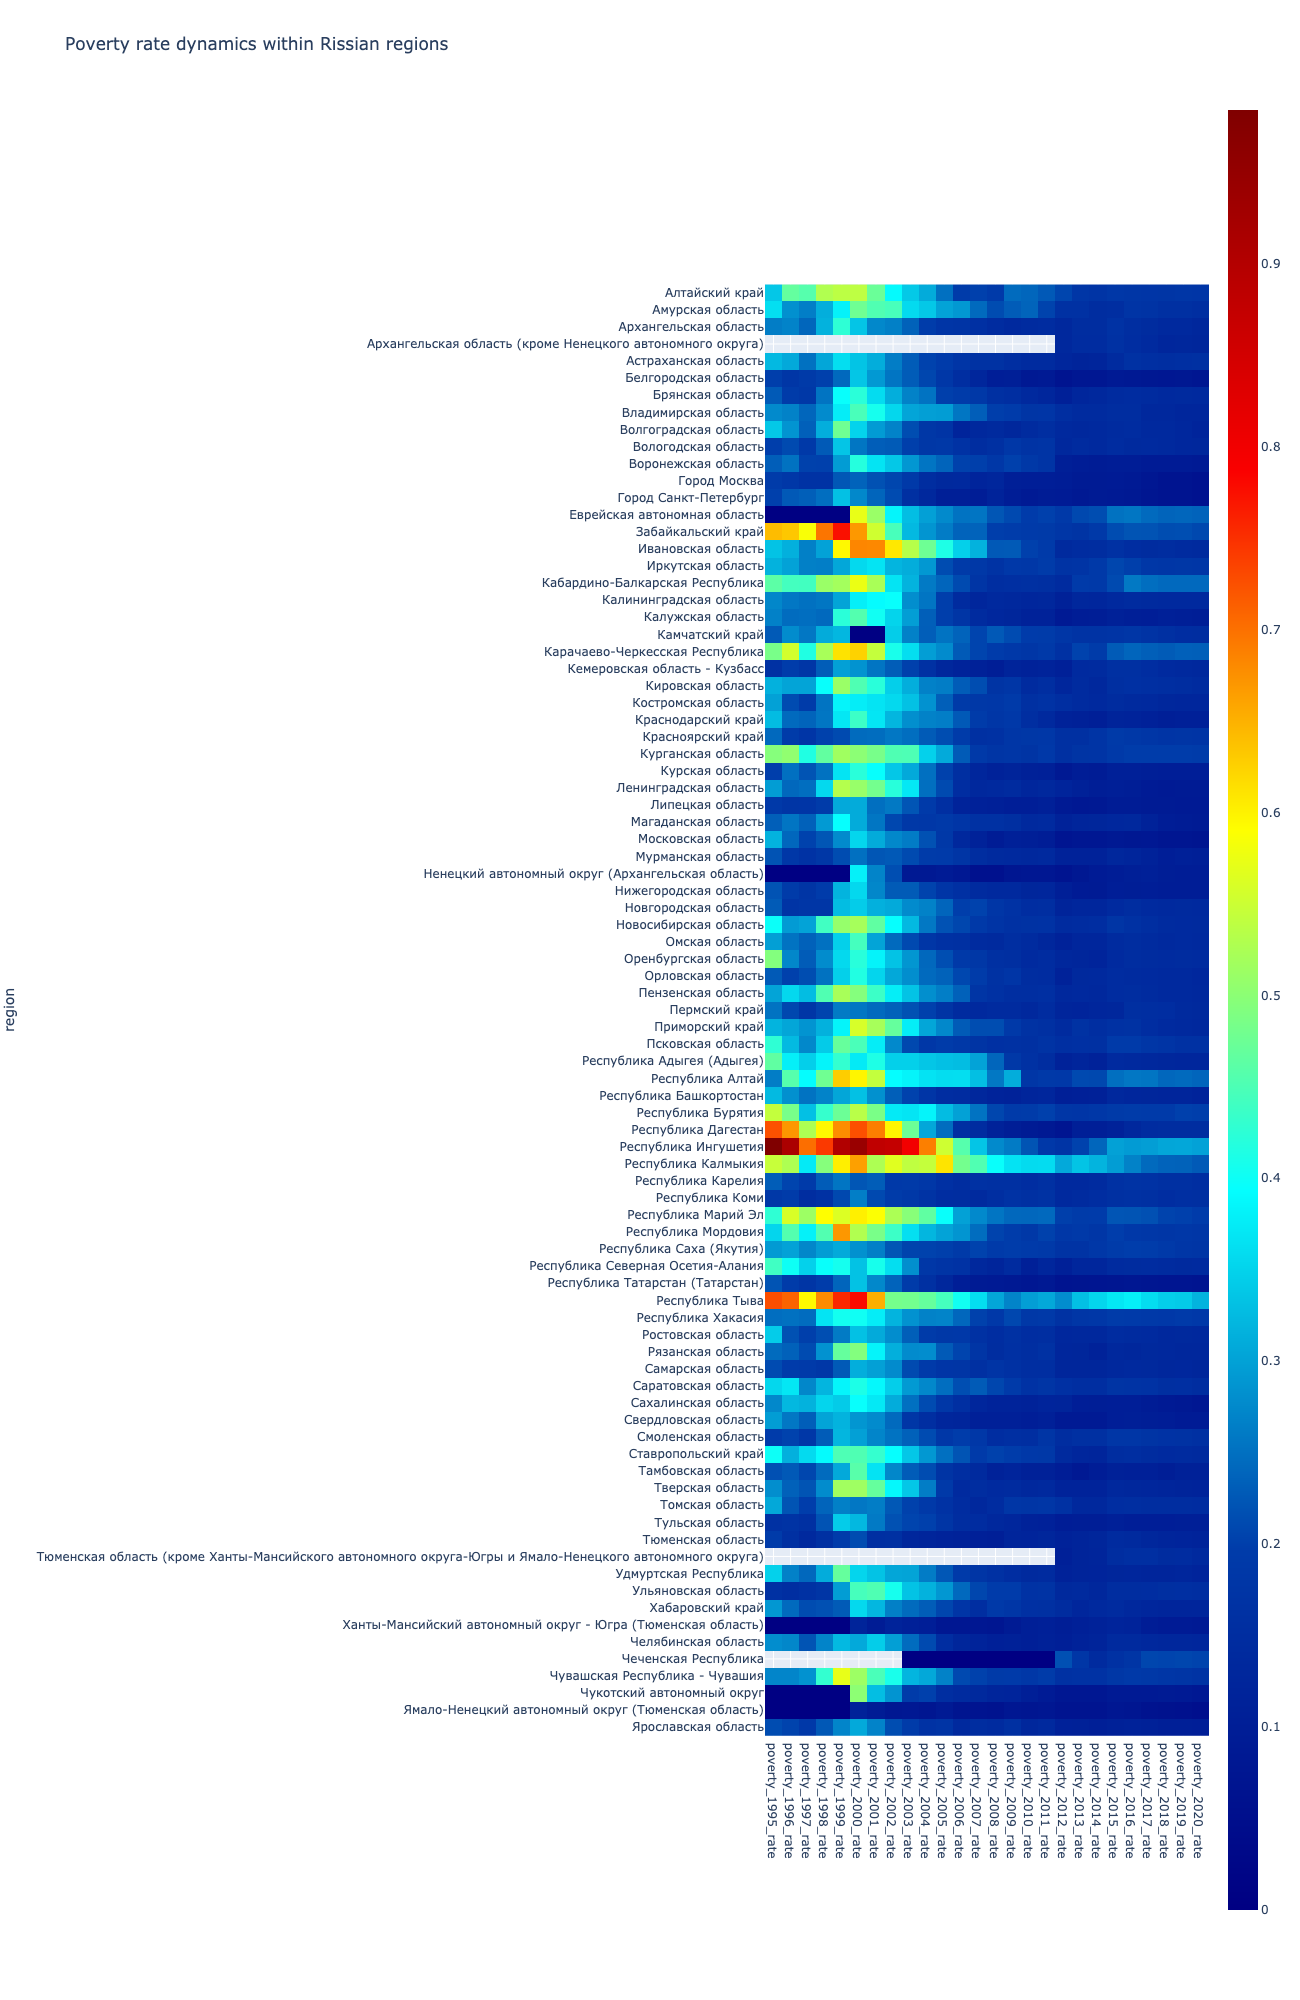

In [ ]:
# Delete the years which have up to 40 % of empty values.
data_poverty = drop_empty_years(data_poverty)

data_poverty_normalized = data_poverty / 100

fig = px.imshow(
    data_poverty_normalized,
    height=2000,
    width=1300,
    color_continuous_scale='Jet',
    title='Poverty rate dynamics within Rissian regions'
)
fig.show('png')

Poverty rate was significant across most of the regions at the turn of the nineties and two thousandths. Most of the regions seem to have overcome this situation, although some still show an increased value of poverty rate, e.g.:
- Еврейская автономная область
- Кабардино-Балкарская Республика
- Карачаево-Черкесская Республика
- Республика Алтай
- Республика Ингушетия
- Республика Тыва

Poverty rate seems to be in a direct indication of an economically weak regions.

### 2.8 Poverty Statisticts in Demografic Context

Data source is loaded and then gets transformed to contain the poverty data within demografic groups per Russion region across the years 2017 and 2020. Columns
1. `region` - name of the region of the Russian Federation. Data for districts uniting multiple regions has been removed.
2. `poverty_dem_children_{year}, poverty_dem_seniors_{year}, poverty_dem_adults_{year}` - columns containing the poverty percentage across the demografic groups for each of the regions in the corresponding year.

In [ ]:
data_poverty_dem_list = []
for year in range(2017, 2021):
    data_poverty_dem = pd.read_excel(f'data/poverty_socdem_{year}.xlsx')
    data_poverty_dem = rename_columns(data_poverty_dem, 'poverty_dem_')
    data_poverty_dem['region'] = data_poverty_dem['region'].str.strip()
    data_poverty_dem = data_poverty_dem.set_index('region', drop=True)
    data_poverty_dem_list.append(data_poverty_dem)
data_poverty_dem = pd.concat(data_poverty_dem_list, axis=1)

data_poverty_dem = data_poverty_dem.sort_index()

Let's visualize the poverty rate in demographic context dynamics in different regions. I will pick the povery among the adults, since this group of population is actively participating in the economy and high poverty rates of adult population might indicate economically weak regions. We'll normalize data in each of the regions separately to get the dynamics within the region.

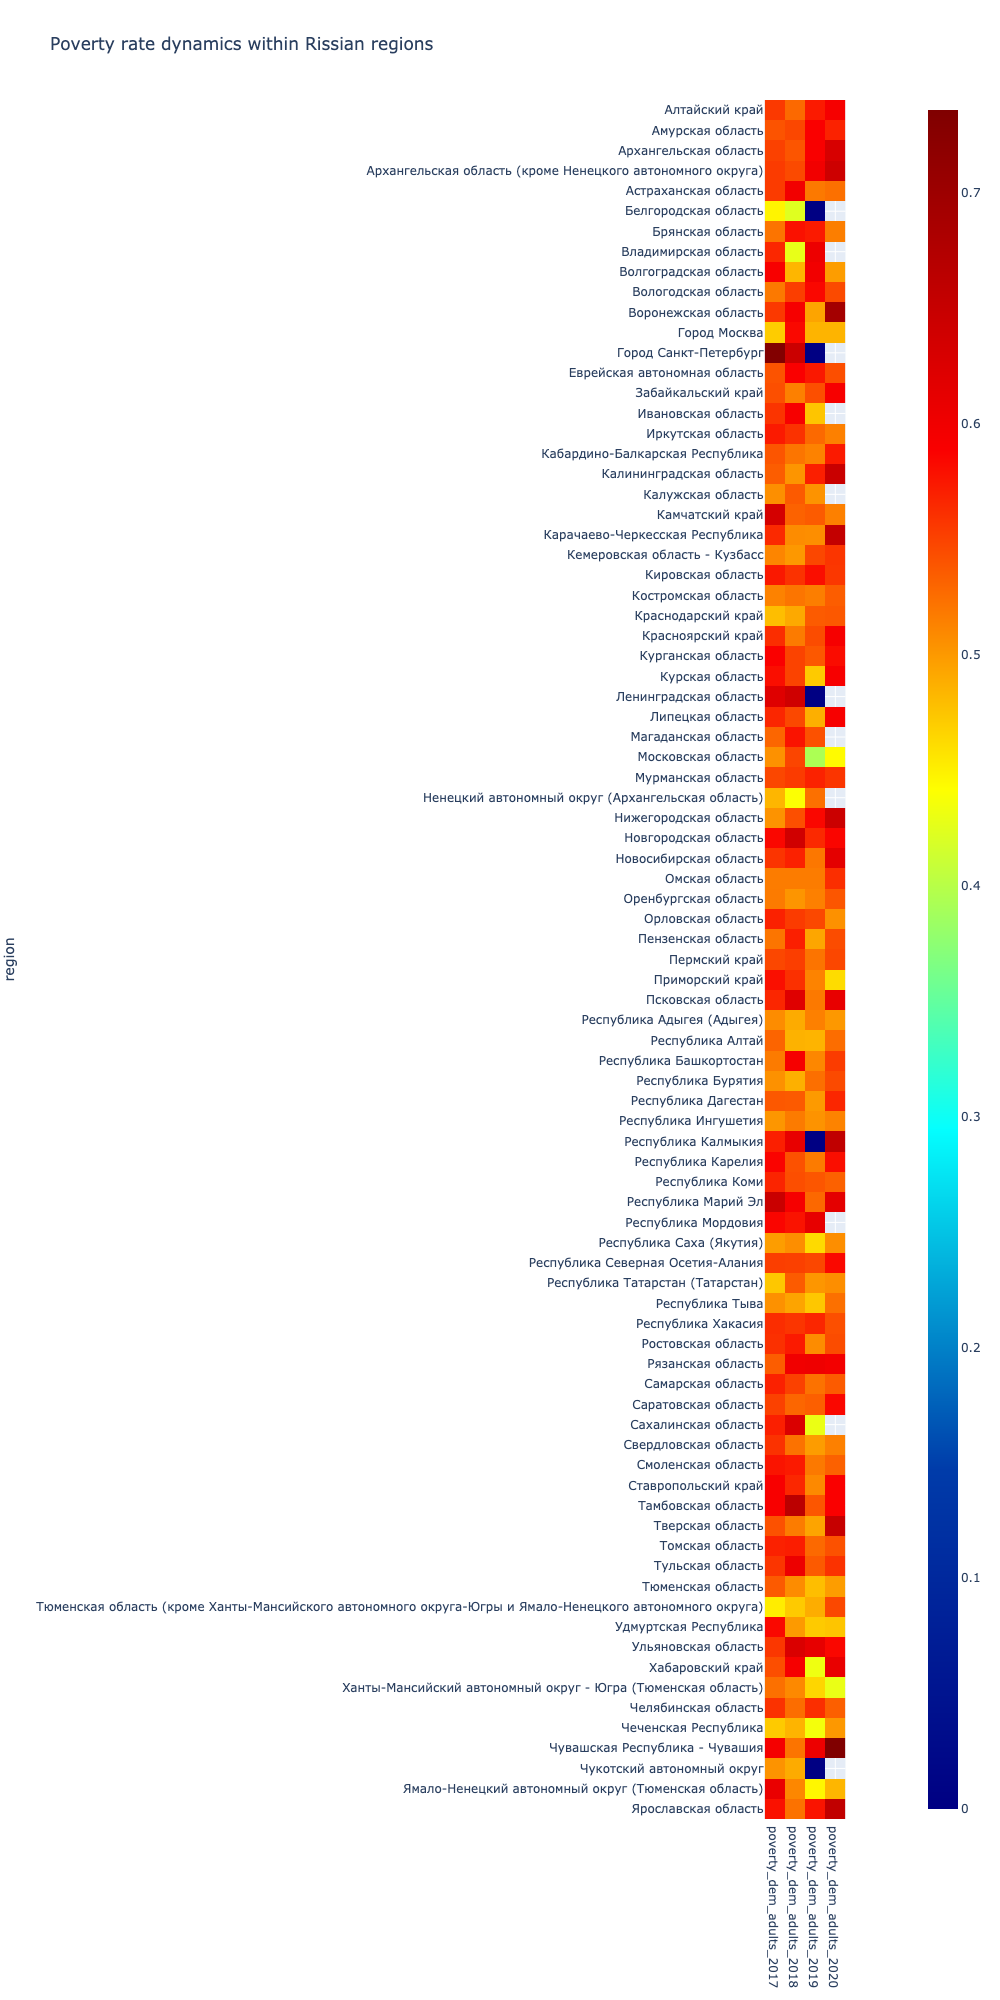

In [ ]:
# Delete the years which have up to 40 % of empty values.
data_poverty_dem = drop_empty_years(data_poverty_dem)

data_poverty_dem_normalized = data_poverty_dem / 100

fig = px.imshow(
    data_poverty_dem_normalized.filter(like='adults', axis=1),
    height=2000,
    width=1000,
    color_continuous_scale='Jet',
    title='Poverty rate dynamics within Rissian regions'
)
fig.show('png')

Only a few regions demonstrate a lower poverty among the adults:
- Город Москва
- Московская область
- Приморский край
- Удмуртская Республика
- Ханты-Мансийский автономный округ - Югра (Тюменская область)
- Ямало-Ненецкий автономный округ (Тюменская область)

These regions should be ending-up in the cluster of the more economically stable regions after the cluster algorithms are applied.

### 2.9 Housing Statistics 2020

#### 2.9.1 Living conditions - size

Data source contains the housing conditions in terms of the living space in the year 2020 across the Russian regions. Columns:
1. `housing_size_в том числе домохозяйства, указавшие, что при проживании не испытывают стесненностиgion` - percentage of the households which declared to have sufficient living space.
2. `housing_size_в том числе домохозяйства, указавшие, что при проживании испытывают определенную стесненность	housing_size_в том числе домохозяйства, указавшие, что при проживании испытывают большую ` - percentage of the households which declared to have some shortage of the living space.
3. `housing_size_в том числе домохозяйства, указавшие, что при проживании испытывают большую стесненность` - percentage of the households which declared to have a considerable shortage of the living space.
4. `housing_size_затруднились ответить` - percentage of the households which found it difficult to anser.
5. `housing_size_Размер общей площади в расчете на члена домохозяйства` - total area size per houshold member.
6. `housing_size_Размер жилой площади в расчете на члена домохозяйства` - living area size per household member.
7. `housing_size_Число жилых комнат в расчете на одно домохозяйство` - number of rooms per household.

In [ ]:
data_housing_size = pd.read_excel(
    'data/housing_2020.xlsx', 
    sheet_name='housing_cond'
)
data_housing_size = rename_columns(data_housing_size, 'housing_size_')
data_housing_size = data_housing_size.set_index('region', drop=True)
data_housing_size = data_housing_size.sort_index()

Let's visualize the housing statistics dynamics in different regions. I will pick the share of the households which experience a considerable tightness in their living conditions for visualization. We'll normalize data in each of the regions separately to get the dynamics within the region.

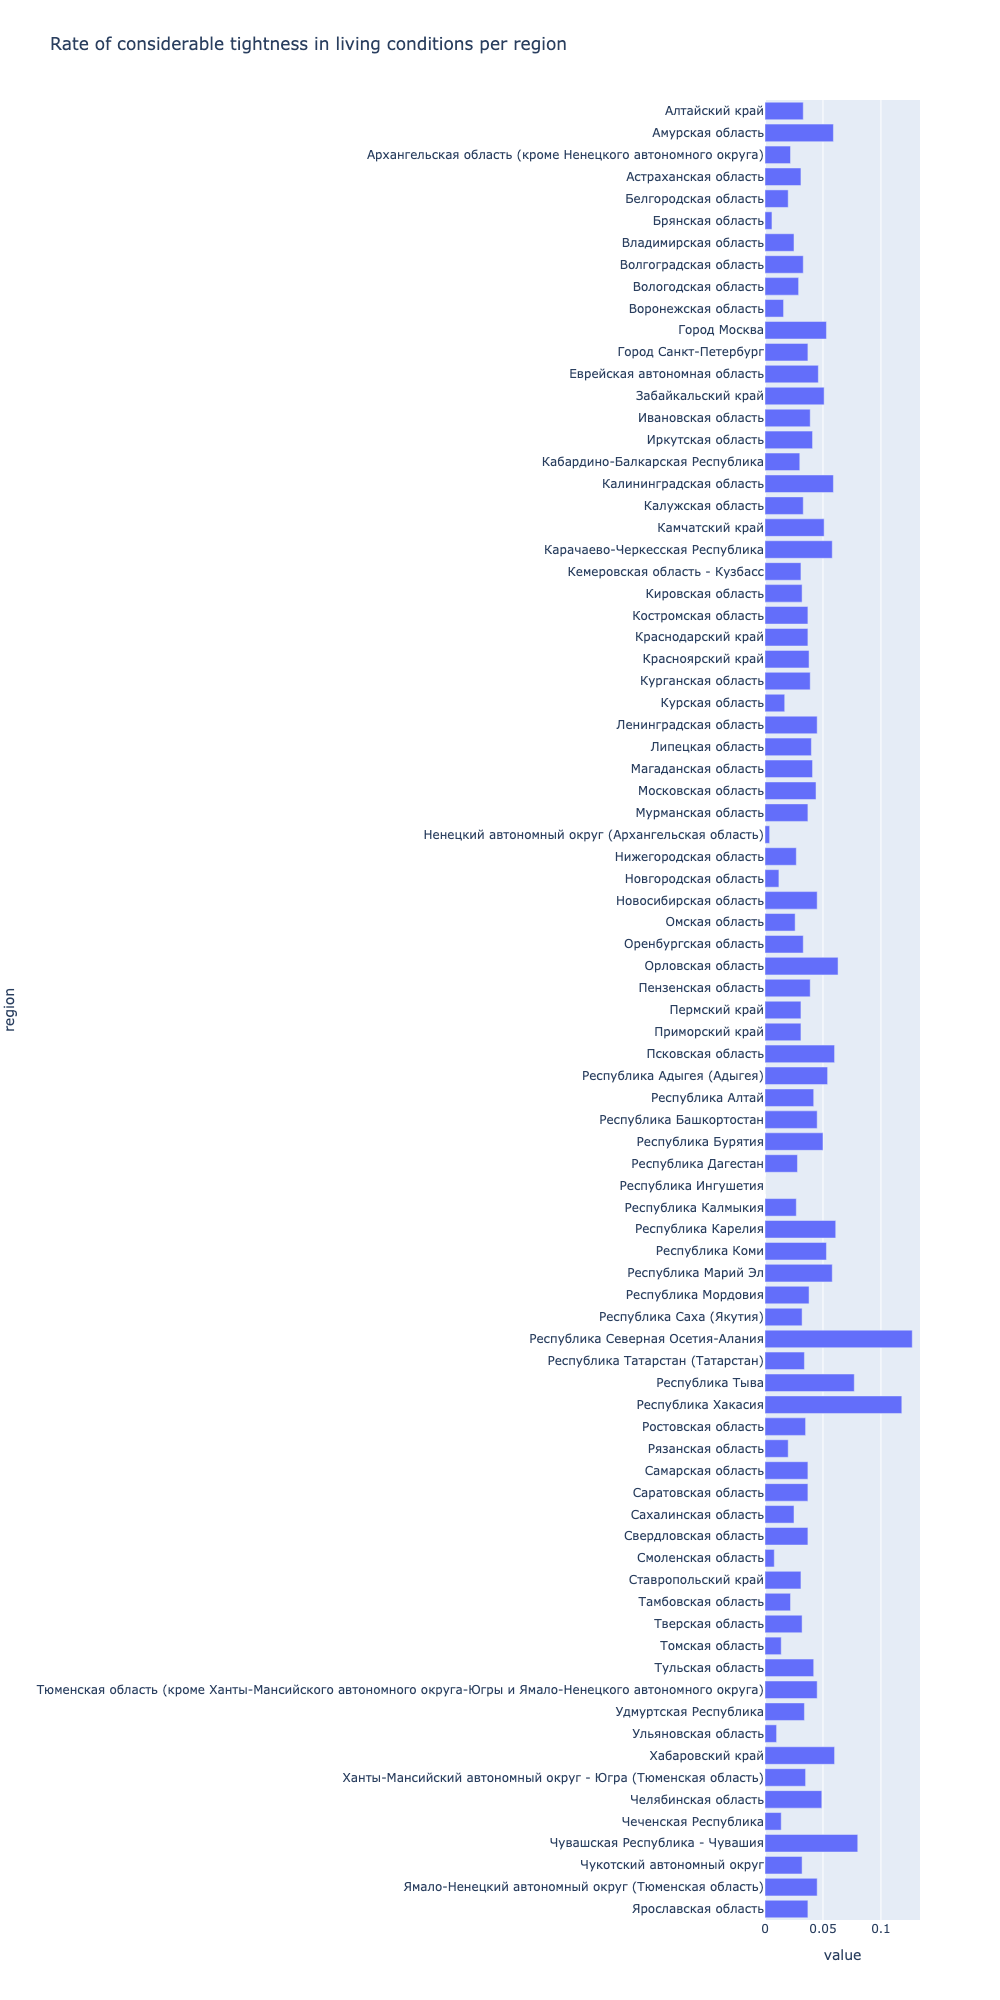

In [ ]:
# Delete the years which have up to 40 % of empty values.
data_housing_size = drop_empty_years(data_housing_size)

data_housing_size_normalized = data_housing_size / 100

fig = px.bar(
    data_housing_size_normalized.filter(like='большую', axis=1).sort_index(ascending=False),
    orientation='h',
    height=2000,
    width=1000,
    title='Rate of considerable tightness in living conditions per region'
)
fig.update_layout(
    showlegend=False
)
fig.show('png')

The following regions demonstrate a high tightness of the living conditions:
- Республика Северная Осетия-Алания
- Республика Тыва
- Республика Хакасия
- Чувашская Республика - Чувашия

Tightness of living conditions could be considered an indication of economically weaker regions. Let's validate this after the cluster algorithms are applied.

#### 2.9.2 Living conditions - state

Data source contains the housing conditions in terms of the state of the house in the year 2020 across the Russian regions. Columns:
1. `housing_state_из них домохозяйства, собирающиеся улучшить свои жилищные условия` - percentage of the households which declared to improve the house state.
2. `housing_state_из них указавшие: на стесненность проживания` - percentage of the households which declared to have not sufficient living space.
3. `housing_state_из них указавшие: на плохое или очень плохое состояние жилого помещения` - percentage of the households which declared to have very poor or poor state of the house.
4. `housing_state_из них указавшие: на плохое состояние или очень плохое состояние жилого помещения и на стесненность проживания` - percentage of the households which declared to have very poor or poor state of the house and do not have sufficient living space.
5. `housing_state_из числа домохозяйств, собирающихся улучшить свои жилищные условия: планируют вселиться в жилое помещение, строительство которого ведут (участвуют в долевом строительстве)` - percentage of the households which declared to improve their living conditions by moving to an object which they are currently building.
6. `housing_state_из числа домохозяйств, собирающихся улучшить свои жилищные условия: собираются подать документы для постановки на очередь (и/или ожидают прохождения очереди)	` - percentage of the households which declared to apply for a social appartment.
7. `housing_state_из числа домохозяйств, собирающихся улучшить свои жилищные условия: рассчитывают на получение нового жилья в связи со сносом дома` - percentage of the households which declared to expect to get a new apartment due to their current house demolition.
8. `housing_state_из числа домохозяйств, собирающихся улучшить свои жилищные условия: собираются купить (построить) другое жилье` - percentage of the households which declared to improve their living conditions by buying a new apartment.
9. `housing_state_из числа домохозяйств, собирающихся улучшить свои жилищные условия: собираются снимать жилье` - percentage of the households which declared to improve their living conditions by renting a different apartment.
10. `housing_state_из числа домохозяйств, собирающихся улучшить свои жилищные условия: собираются улучшить свои жилищные условия другим способом` - percentage of the households which declared to improve their living conditions by some other means.
11. `housing_state_затруднились ответить` - percentage of the households which found it difficult to anser.
12. `housing_state_домохозяйства, не собирающиеся улучшать свои жилищные условия` - percentage of the households which do not plan to improve their living conditions.

In [ ]:
data_housing_state = pd.read_excel(
    'data/housing_2020.xlsx', 
    sheet_name='housing_intent'
)
data_housing_state = rename_columns(data_housing_state, 'housing_state_')
data_housing_state = data_housing_state.set_index('region', drop=True)
data_housing_state = data_housing_state.sort_index()

Let's visualize the housing statistics dynamics in different regions. I will pick the share of the households which experience a poor state of the housing and a considerable tightness in their living conditions for visualization. We'll normalize data in each of the regions separately to get the dynamics within the region.

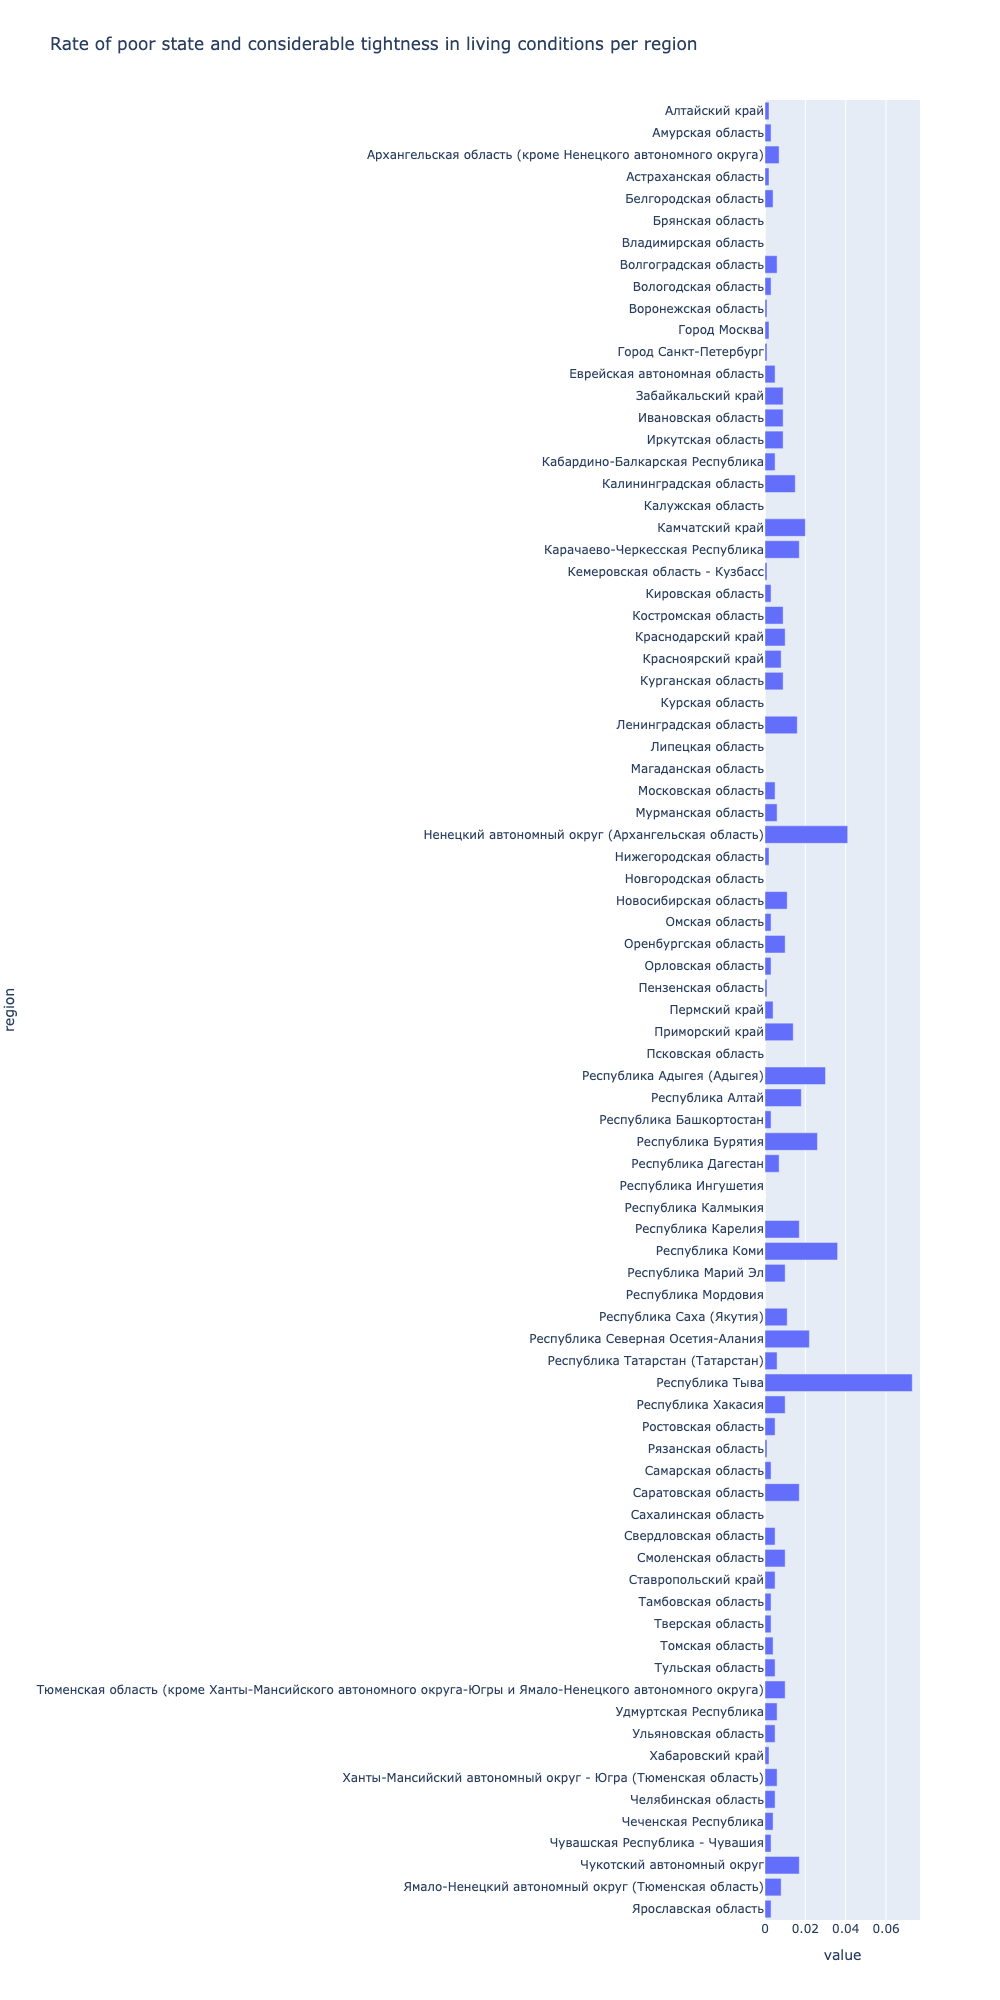

In [ ]:
# Delete the years which have up to 40 % of empty values.
data_housing_state = drop_empty_years(data_housing_state)

data_housing_state_normalized = data_housing_state / 100

fig = px.bar(
    data_housing_state_normalized.filter(
        like='и на стесненность проживания', 
        axis=1
    ).sort_index(ascending=False),
    orientation='h',
    height=2000,
    width=1000,
    title='Rate of poor state and considerable tightness in living conditions per region'
)
fig.update_layout(
    showlegend=False
)
fig.show('png')

The following regions demonstrate poor state and a high tightness of the living conditions:
- Ненецкий автономный округ (Архангельская область)
- Республика Адыгея (Адыгея)
- Республика Коми
- Республика Тыва

Poor state and tightness of living conditions could be considered an indication of economically weaker regions. Let's validate this after the cluster algorithms are applied.

### 2.10 Gross Regional Product statistics per capita

Data source contains per capita gross regional product in roubles per Russian region across the years 1996 and 2020. Columns:
1. `region` - name of the region of the Russian Federation. Data for districts uniting multiple regions has been removed.
2. `gross_product_1996-gross_product_2020` - columns containing the per capita gross regional product in roubles for each of the regions in the corresponding year.

In [ ]:
data_gross_product = pd.read_excel(
    'data/gross_regional_product_1996_2020.xlsx', 
    sheet_name='data'
)
data_gross_product['region'] = data_gross_product['region'].str.strip()
data_gross_product = data_gross_product.set_index('region', drop=True)
data_gross_product = data_gross_product.sort_index()

Let's visualize the gross regional product dynamics in different regions. We'll normalize data in each of the regions separately to get the dynamics within the region.

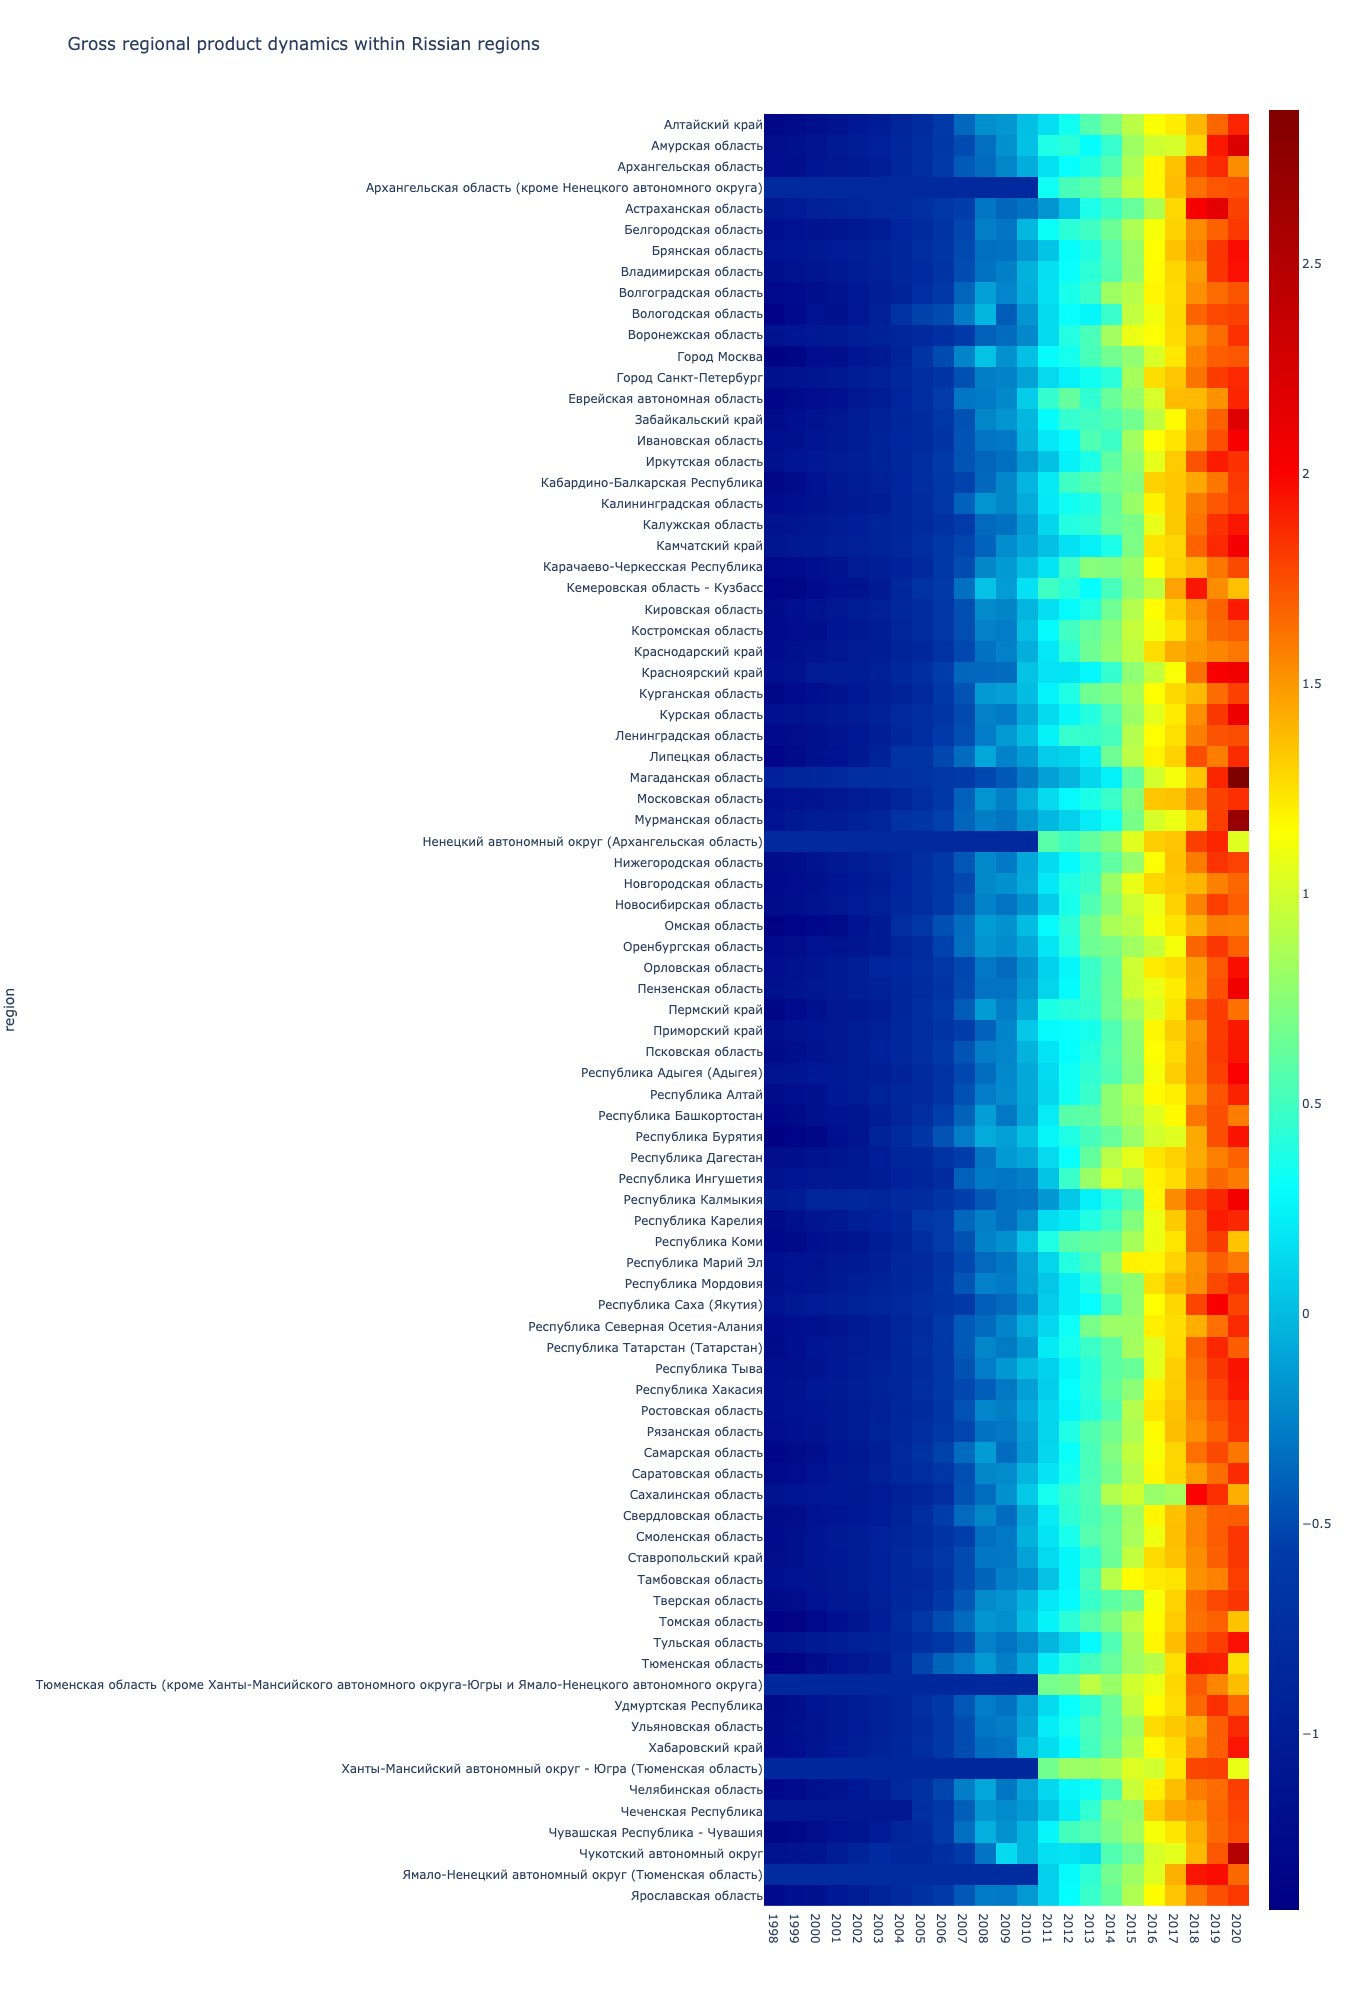

In [ ]:
# Delete the years which have up to 40 % of empty values.
data_gross_product = drop_empty_years(data_gross_product)

data_gross_product_normalized = normalize_data(data_gross_product)

fig = px.imshow(
    data_gross_product_normalized,
    height=2000,
    width=1350,
    color_continuous_scale='Jet',
    title='Gross regional product dynamics within Rissian regions'
)
fig.show('png')

Overall there was a considerable gross regional product growth since 1996. However some of the regions demonstrate limited growth dynamics:
- Кемеровская область - Кузбасс
- Ненецкий автономный округ (Архангельская область)
- Республика Коми
- Сахалинская область
- Томская область
- Тюменская область
- Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)
- Ханты-Мансийский автономный округ - Югра (Тюменская область)

Low gross product per capita growth indicates that the affected regions are economically weak.

### 2.11 Regional production statistics

Data source contains Russian regions's total production in roubles per across the years 1996 and 2020. Data from different industries has been aggregated to form a single total value. Columns:
1. `region` - name of the region of the Russian Federation. Data for districts uniting multiple regions has been removed.
2. `production_2005-production_2020` - columns containing the regions' total production in roubles for each of the regions in the corresponding year.

In [ ]:
data_production = pd.read_excel('data/regional_production_2005_2016.xlsx', header=1)
data_production['region'] = data_production['region'].str.strip()
data_production = data_production.groupby('region').sum()

data_production_2 = pd.read_excel('data/regional_production_2017_2020.xlsx', header=1)
data_production_2['region'] = data_production_2['region'].str.strip()
data_production_2 = data_production_2.groupby('region').sum()

data_production = pd.concat([data_production, data_production_2], axis=1)
data_production = data_production.sort_index()
data_production.columns = data_production.columns.map(str)

Let's visualize the produciton dynamics in different regions. We'll normalize data in each of the regions separately to get the dynamics within the region.

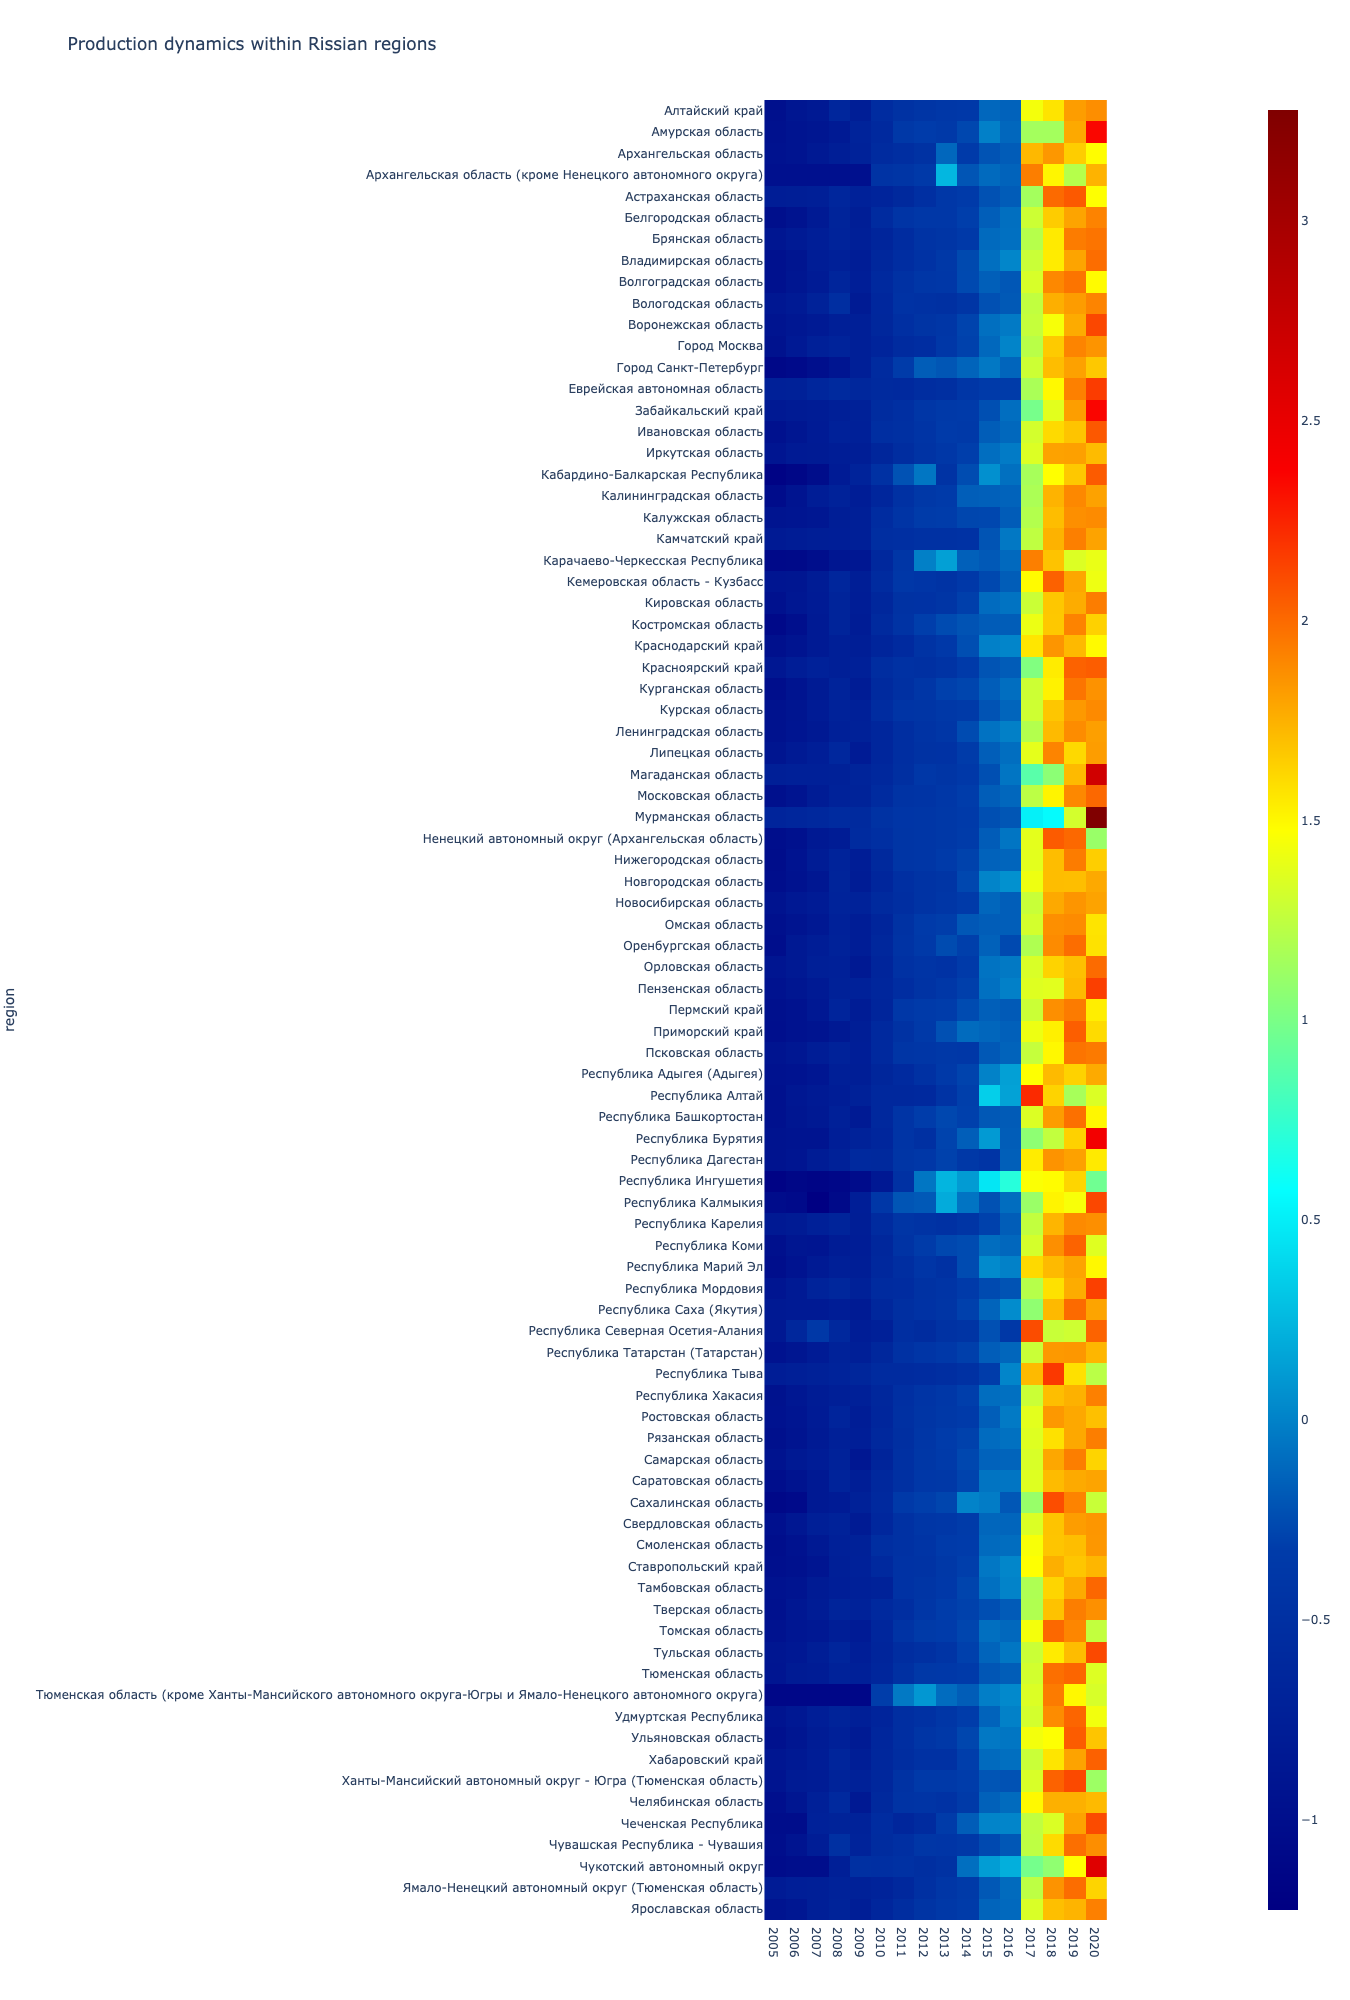

In [ ]:
# Delete the years which have up to 40 % of empty values.
data_production = drop_empty_years(data_production)

data_production_normalized = normalize_data(data_production)

fig = px.imshow(
    data_production_normalized,
    height=2000,
    width=1350,
    color_continuous_scale='Jet',
    title='Production dynamics within Rissian regions'
)
fig.show('png')

Most of the reqions demonstrate growth in produciton, although there are some exceptions:
- Ненецкий автономный округ (Архангельская область)
- Республика Ингушетия
- Республика Тыва
- Сахалинская область
- Томская область
- Тюменская область
- Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)
- Ханты-Мансийский автономный округ - Югра (Тюменская область)

Lower production growth indicates economic weakness, let's take a look whre these regions end-up after the cluster algorithms are applied.

### 2.12 Retail turnover statistics

Data source contains per capita yearly retail turnover in roubles per Russian region across the years 2015 and 2020. Columns:
1. `region` - name of the region of the Russian Federation. Data for districts uniting multiple regions has been removed.
2. `retail_turnover_2000-retail_turnover_2021` - columns containing the per capita yearly retail turnover in roubles for each of the regions in the corresponding year.

In [ ]:
data_retail_turnover = pd.read_excel('data/retail_turnover_per_capita_2000_2021.xlsx')
data_retail_turnover['region'] = data_retail_turnover['region'].str.strip()
data_retail_turnover = data_retail_turnover.set_index('region')
data_retail_turnover = data_retail_turnover.sort_index()

Let's visualize the retail turnover dynamics in different regions. We'll normalize data in each of the regions separately to get the dynamics within the region.

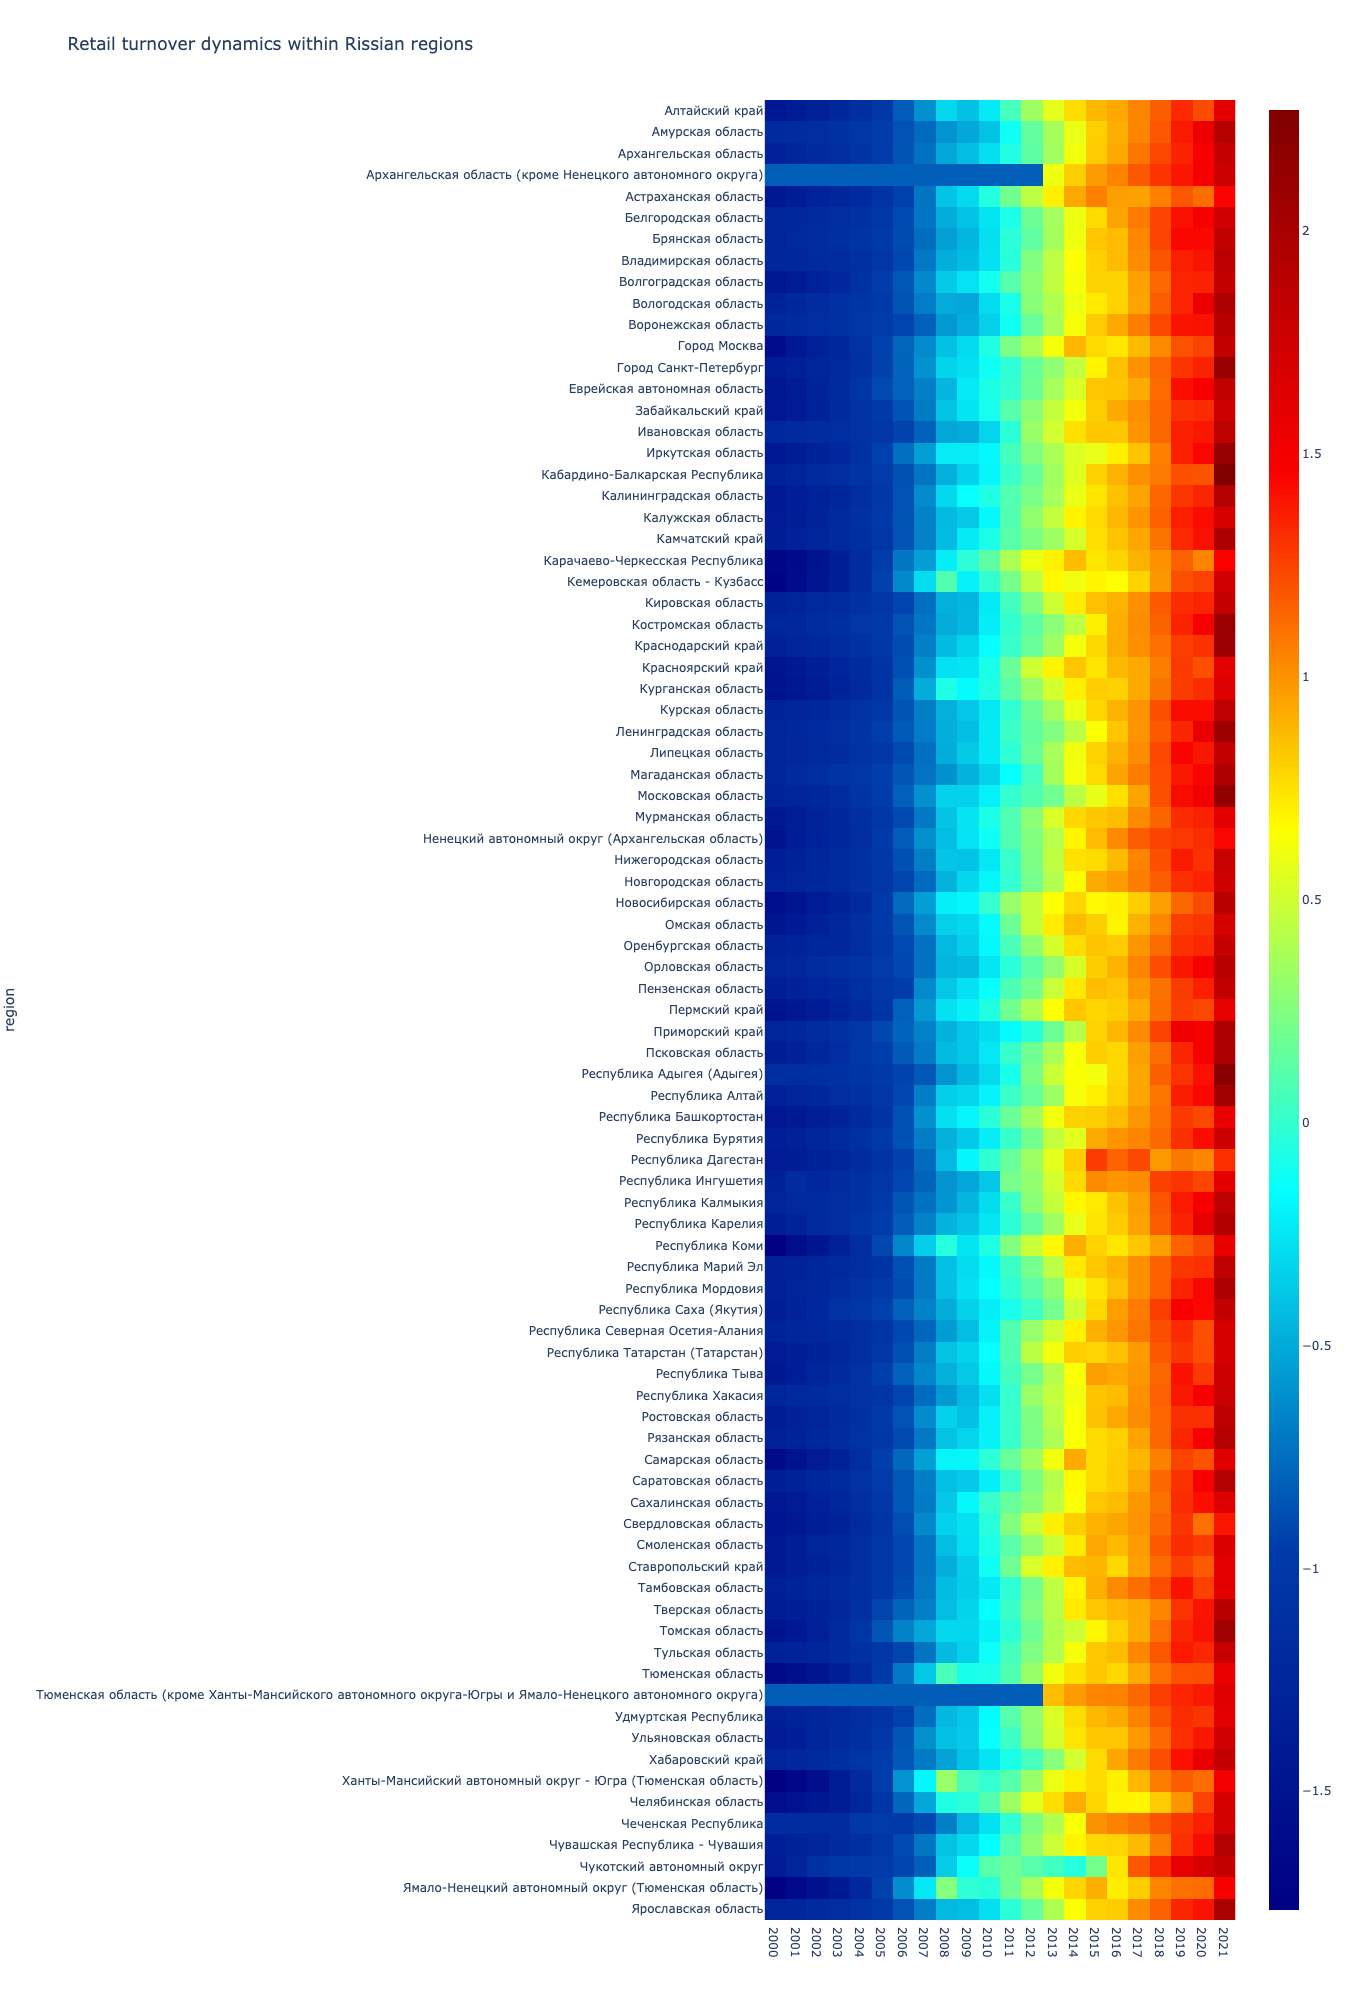

In [ ]:
# Delete the years which have up to 40 % of empty values.
data_retail_turnover = drop_empty_years(data_retail_turnover)

data_retail_turnover_normalized = normalize_data(data_retail_turnover)

fig = px.imshow(
    data_retail_turnover_normalized,
    height=2000,
    width=1350,
    color_continuous_scale='Jet',
    title='Retail turnover dynamics within Rissian regions'
)
fig.show('png')

All regions show a significant growth in retail turnover in the years between 2000 and 2021. Only a few of them demonstrate a less significant growth, like:
- Астраханская область
- Карачаево-Черкесская Республика
- Республика Дагестан
- Республика Коми
- Ханты-Мансийский автономный округ - Югра (Тюменская область)
- Ямало-Ненецкий автономный округ (Тюменская область)

Retail turnover growth might indicate economic development of a region. Lower growth value could mean that the affected regions have a weaker econiomic development.

### 2.13 Income situation

#### 2.13.1 Per capita monthly cash income

Data source contains per capita monthly income in roubles per Russian region across the years 2015 and 2020. Columns:
1. `region` - name of the region of the Russian Federation. Data for districts uniting multiple regions has been removed.
2. `monthly_income_2015-monthly_income_2020` - columns containing the per capita monthly cash income in roubles for each of the regions in the corresponding year.

In [ ]:
data_monthly_cash_income = pd.read_excel(
    'data/cash_real_income_wages_2015_2020.xlsx', 
    sheet_name='per_capita_cash_income'
)
data_monthly_cash_income = data_monthly_cash_income.set_index('region', drop=True)
data_monthly_cash_income = data_monthly_cash_income.sort_index()

Let's visualize the per capita monthly cash income dynamics in different regions. We'll normalize data in each of the regions separately to get the dynamics within the region.

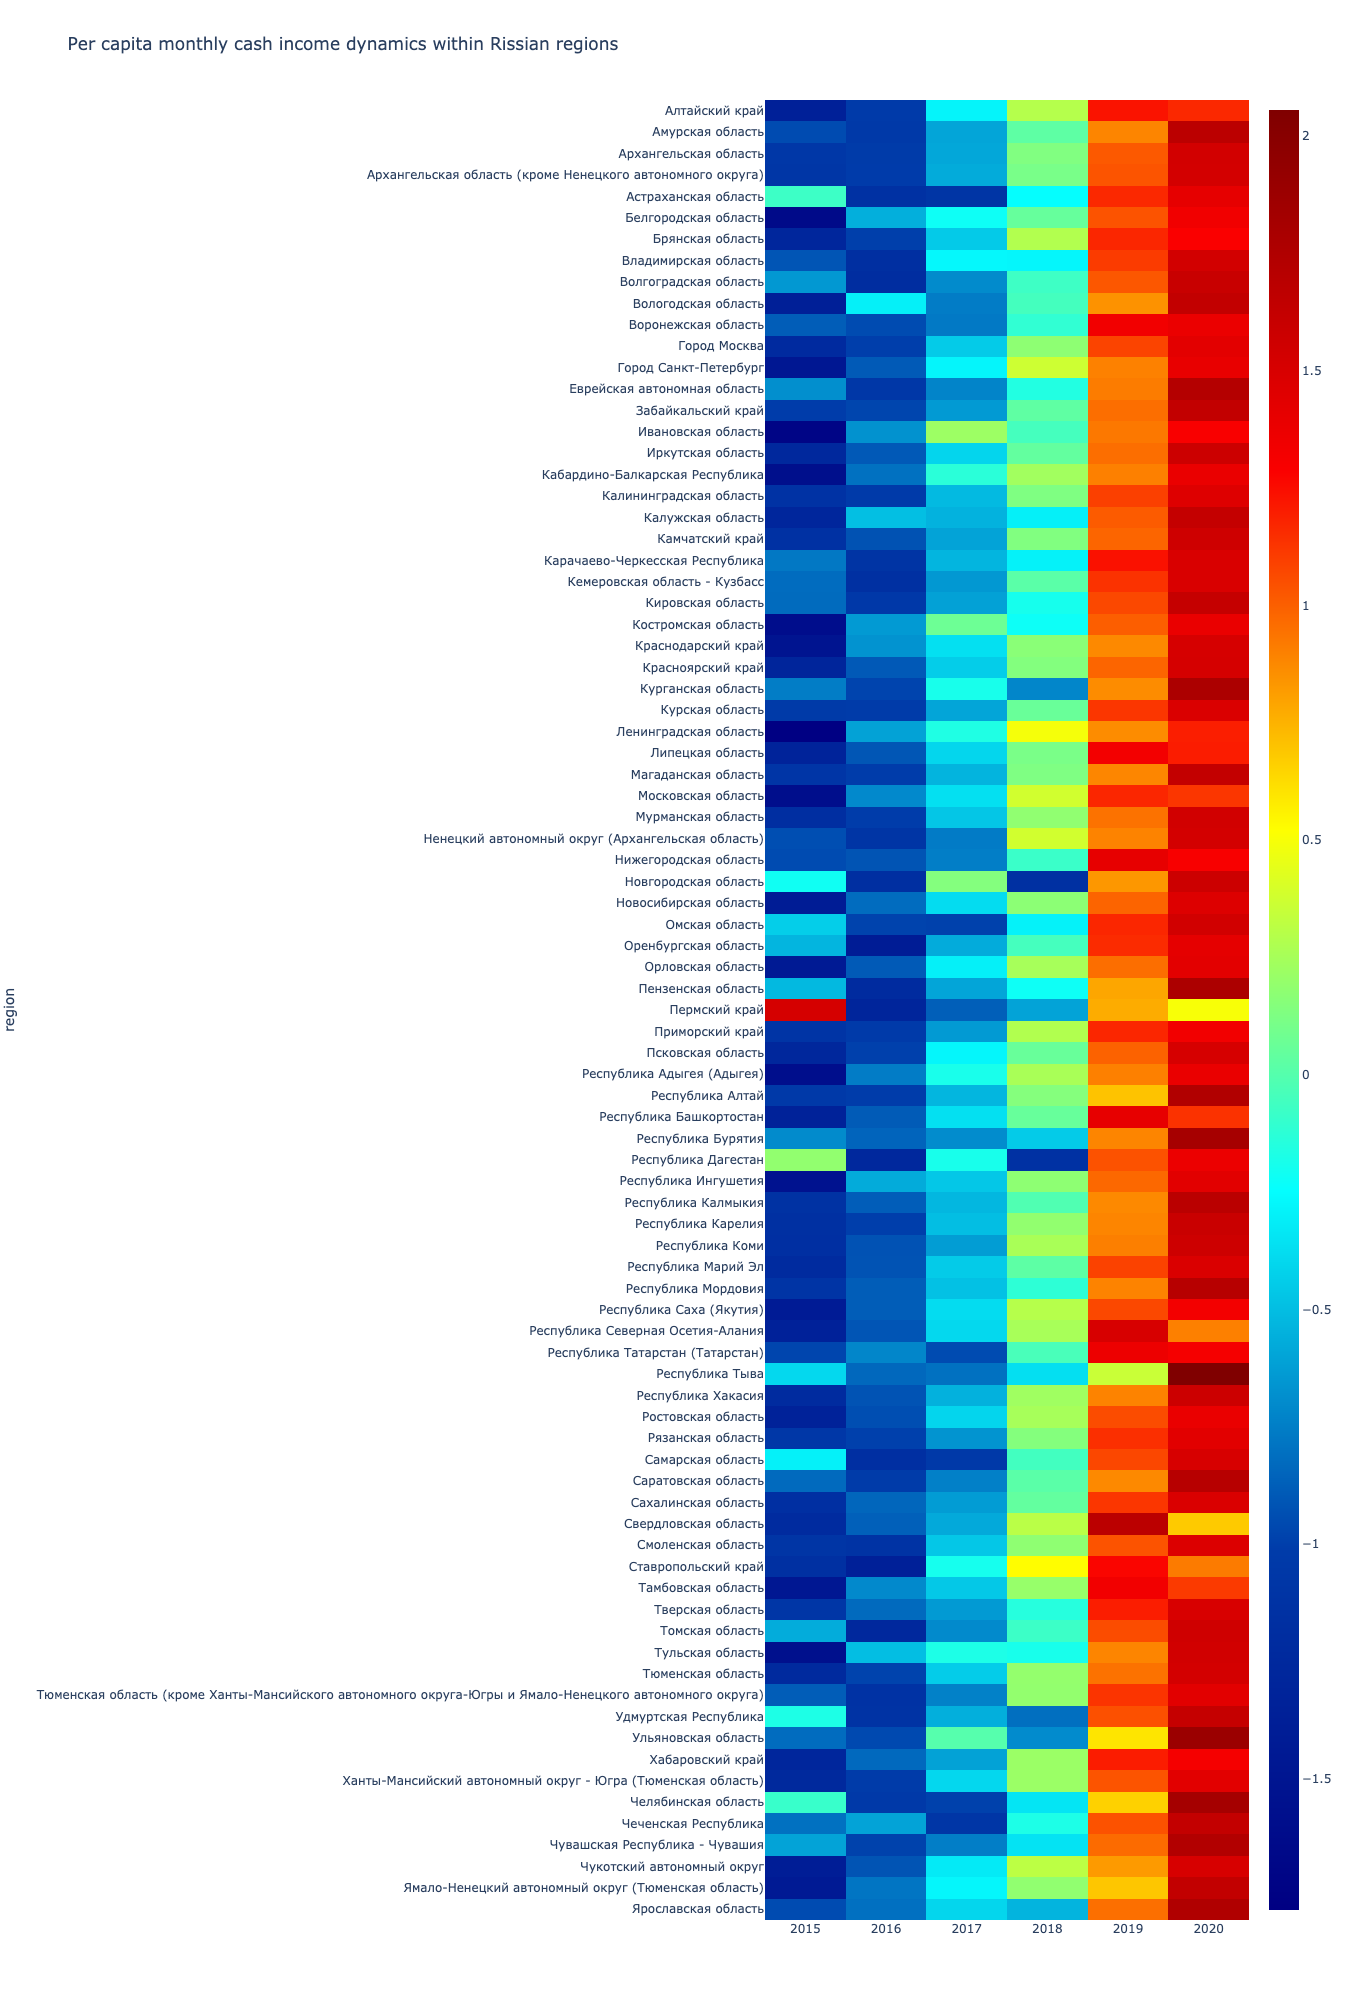

In [ ]:
# Delete the years which have up to 40 % of empty values.
data_monthly_cash_income = drop_empty_years(data_monthly_cash_income)

data_monthly_cash_income_normalized = normalize_data(data_monthly_cash_income)

fig = px.imshow(
    data_monthly_cash_income_normalized,
    height=2000,
    width=1350,
    color_continuous_scale='Jet',
    title='Per capita monthly cash income dynamics within Rissian regions'
)
fig.show('png')

Also here most of the regions demonstrate growth in the dynamics of the per capita monthly cash income with the exception of the following regions:
- Пермский край
- Республика Северная Осетия-Алания
- Свердловская область
- Ставропольский край

Lower per capita monthly cash income growth indicates economically weaker regions.

#### 2.13.2 Real cash income

Data source contains real cash income in percent compared to the previous year per Russian region across the years 2015 and 2020. Columns:
1. `region` - name of the region of the Russian Federation. Data for districts uniting multiple regions has been removed.
2. `real_income_2015-real_income_2020` - columns containing the real cash income in percent compared to the previous year for each of the regions in the corresponding year.

In [ ]:
data_real_cash_income = pd.read_excel(
    'data/cash_real_income_wages_2015_2020.xlsx', 
    sheet_name='real_incomes'
)
data_real_cash_income = data_real_cash_income.set_index('region', drop=True)
data_real_cash_income = data_real_cash_income.sort_index()

Let's visualize the real cash income dynamics in percent to previous year in different regions. We'll normalize data in each of the regions separately to get the dynamics within the region.

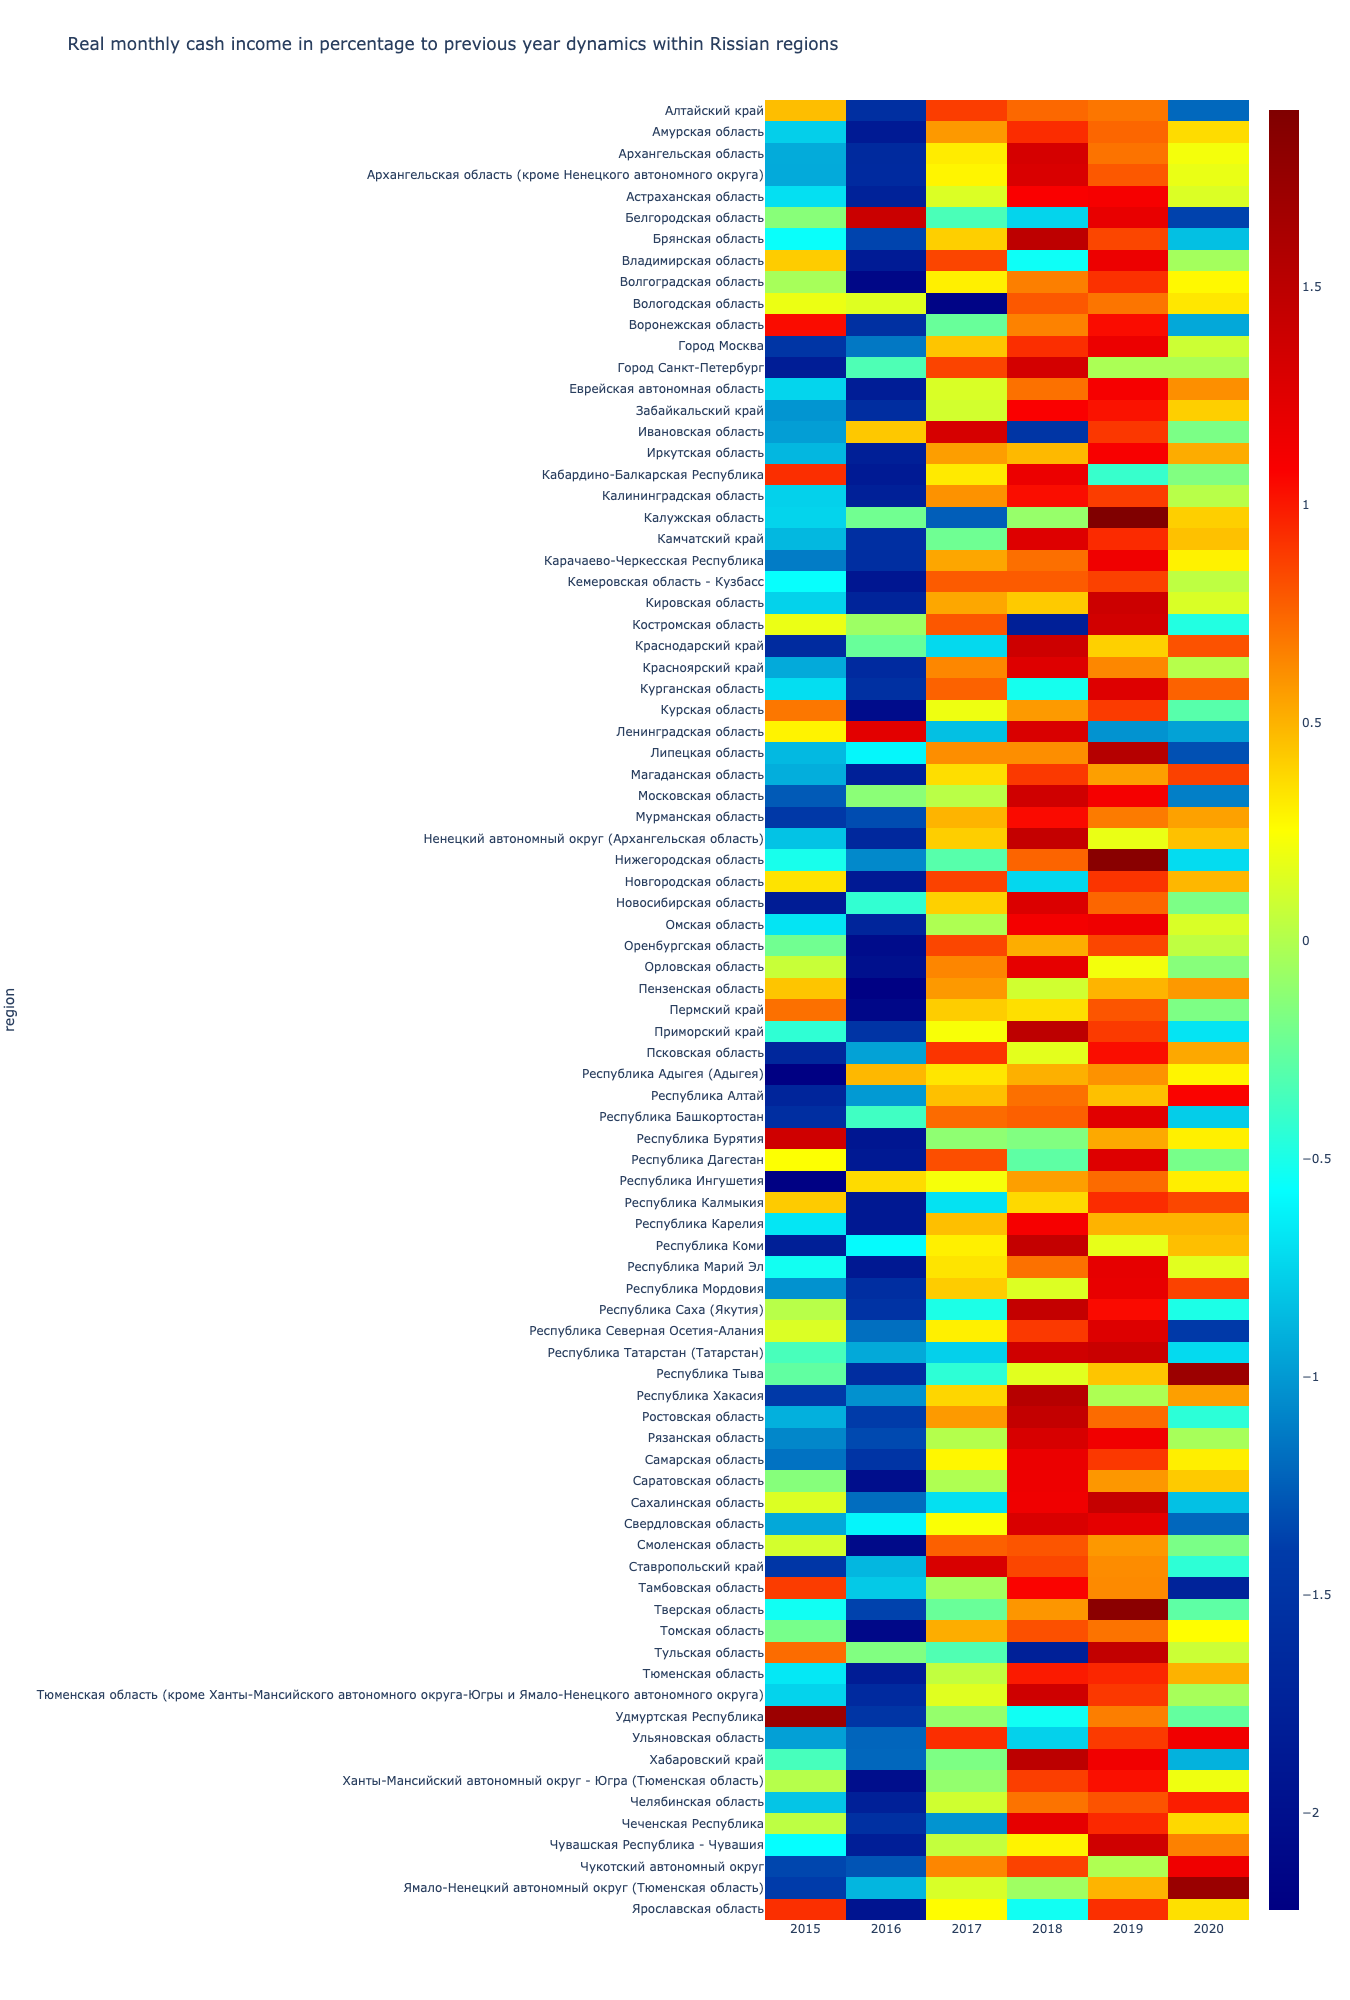

In [ ]:
# Delete the years which have up to 40 % of empty values.
data_real_cash_income = drop_empty_years(data_real_cash_income)

data_real_cash_income_normalized = normalize_data(data_real_cash_income)

fig = px.imshow(
    data_real_cash_income_normalized,
    height=2000,
    width=1350,
    color_continuous_scale='Jet',
    title='Real monthly cash income in percentage to previous year dynamics within Rissian regions'
)
fig.show('png')

The year 2020 was a covid year and thus this year alone cannot be an indication of economic weakness. Let's consider the regions which have low real cash income dynamics in the years 2019 and 2020 as candidates for poor economic development:
- Город Санкт-Петербург
- Кабардино-Балкарская Республика
- Ленинградская область
- Орловская область

#### 2.13.3 Per capita monthly formal wage

Data source contains per capita monthly formal wage in roubles per Russian region across the years 2015 and 2020. Columns:
1. `region` - name of the region of the Russian Federation. Data for districts uniting multiple regions has been removed.
2. `monthly_wage_2015-monthly_wage_2020` - columns containing per capita monthly formal wage in roubles for each of the regions in the corresponding year.

In [ ]:
data_monthly_formal_wage = pd.read_excel(
    'data/cash_real_income_wages_2015_2020.xlsx', 
    sheet_name='formal_wage_paid'
)
data_monthly_formal_wage = data_monthly_formal_wage.set_index('region', drop=True)
data_monthly_formal_wage = data_monthly_formal_wage.sort_index()

Let's visualize the per capita monthly formal wage dynamics in different regions. We'll normalize data in each of the regions separately to get the dynamics within the region.

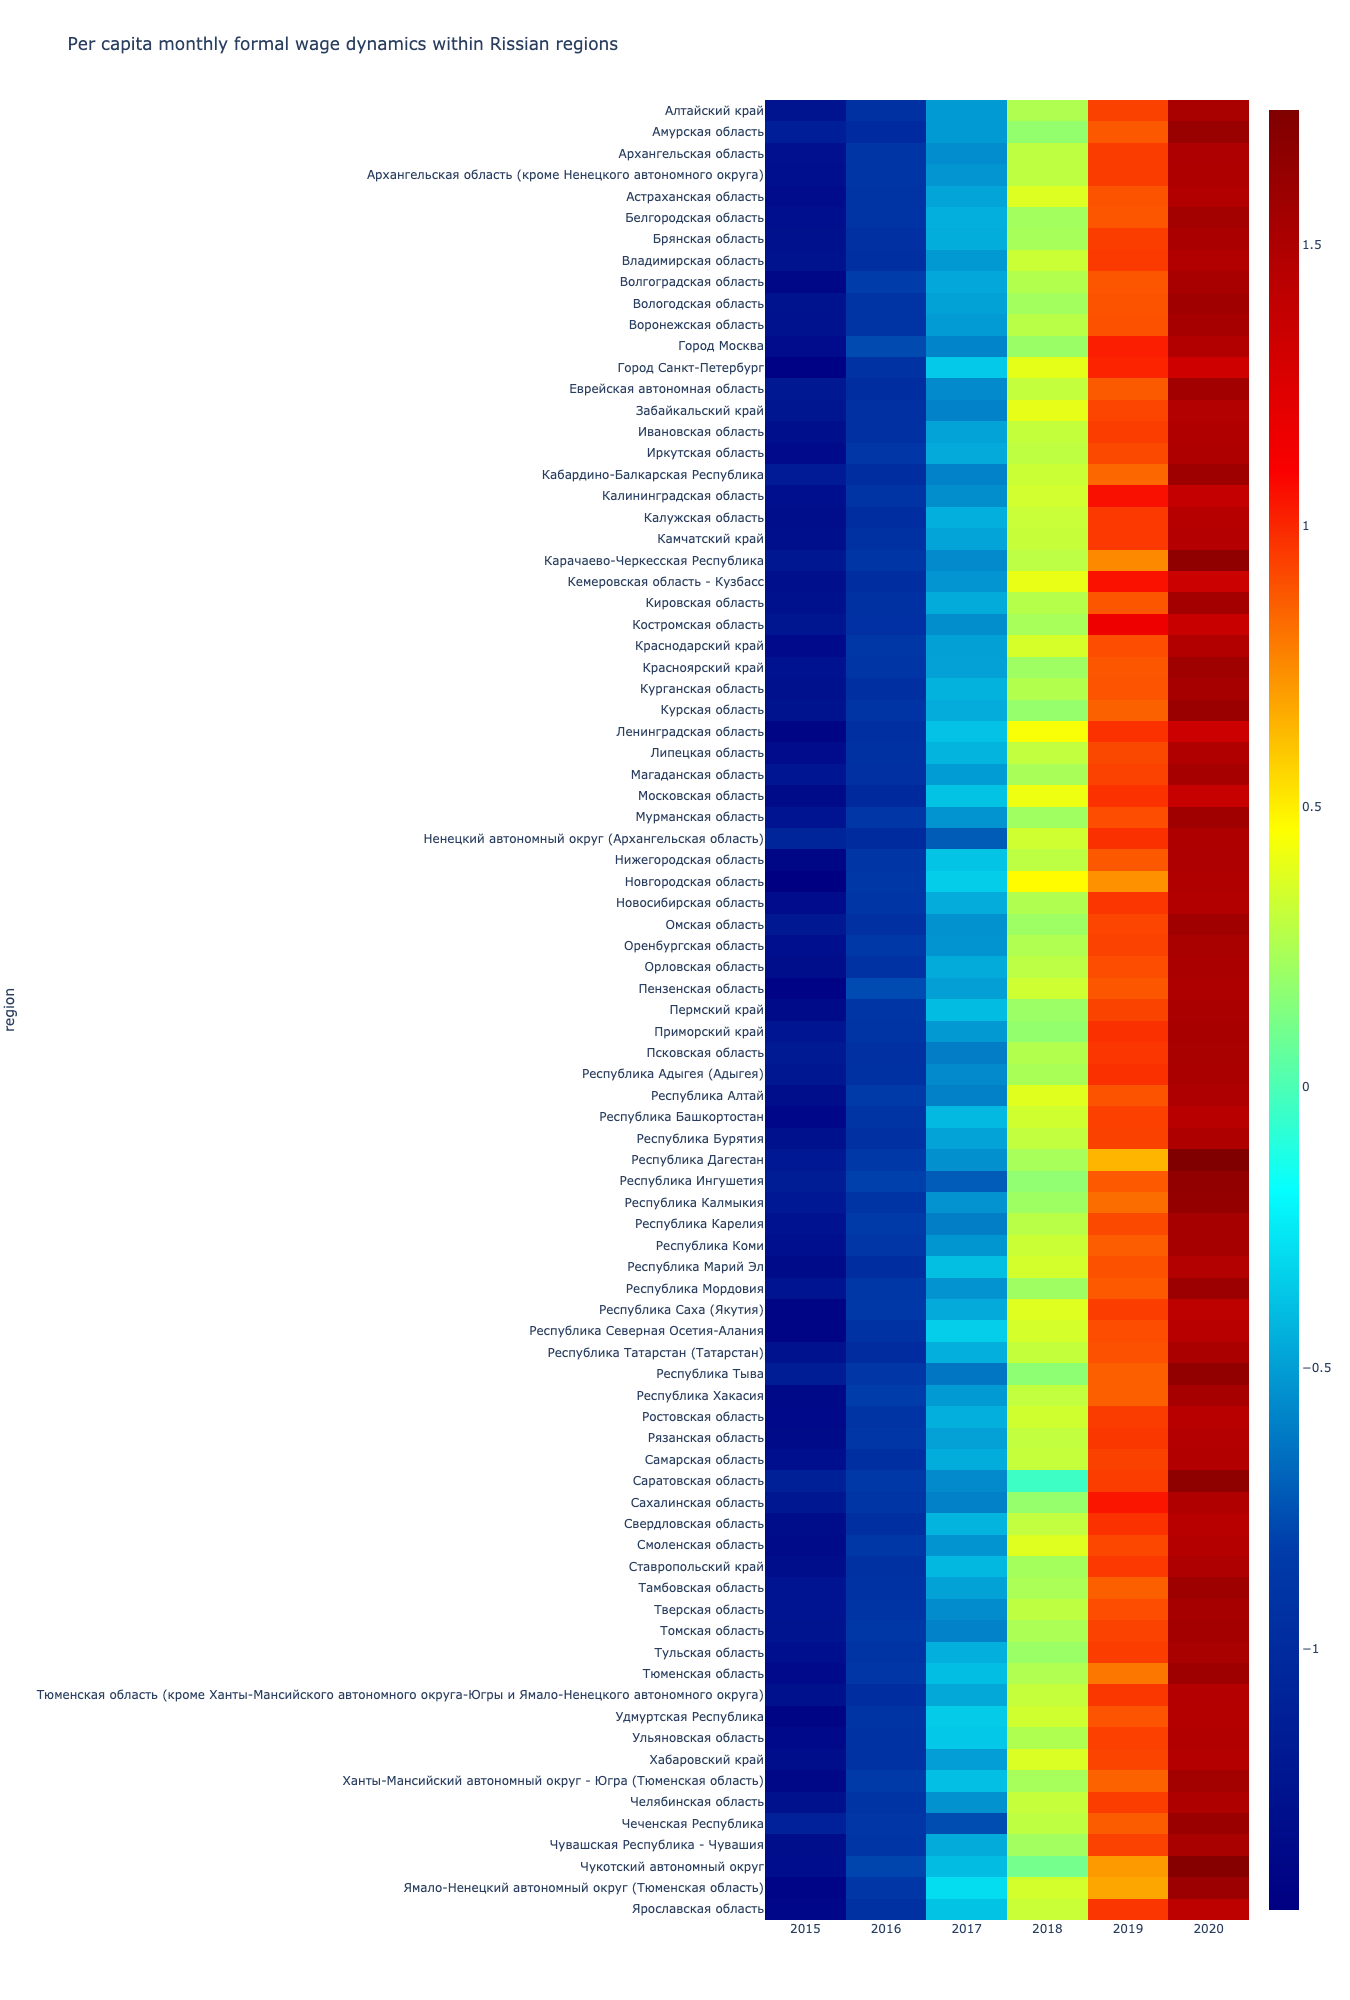

In [ ]:
# Delete the years which have up to 40 % of empty values.
data_monthly_formal_wage = drop_empty_years(data_monthly_formal_wage)

data_monthly_formal_wage_normalized = normalize_data(data_monthly_formal_wage)

fig = px.imshow(
    data_monthly_formal_wage_normalized,
    height=2000,
    width=1350,
    color_continuous_scale='Jet',
    title='Per capita monthly formal wage dynamics within Rissian regions'
)
fig.show('png')

Visually there are no outliers in the formal monthly wage per capita across different regions.

#### 2.13.4 Real wage

Data source contains real wage in percent compared to the previous year per Russian region across the years 2015 and 2020. Columns:
1. `region` - name of the region of the Russian Federation. Data for districts uniting multiple regions has been removed.
2. `real_wage_2015-real_wage_2020` - columns containing the real wage in percent compared to the previous year for each of the regions in the corresponding year.

In [ ]:
data_real_wage = pd.read_excel(
    'data/cash_real_income_wages_2015_2020.xlsx', 
    sheet_name='real_pay'
)
data_real_wage = data_real_wage.set_index('region', drop=True)
data_real_wage = data_real_wage.sort_index()

Let's visualize the real wage dynamics in percent compared to the previous year in different regions. We'll normalize data in each of the regions separately to get the dynamics within the region.

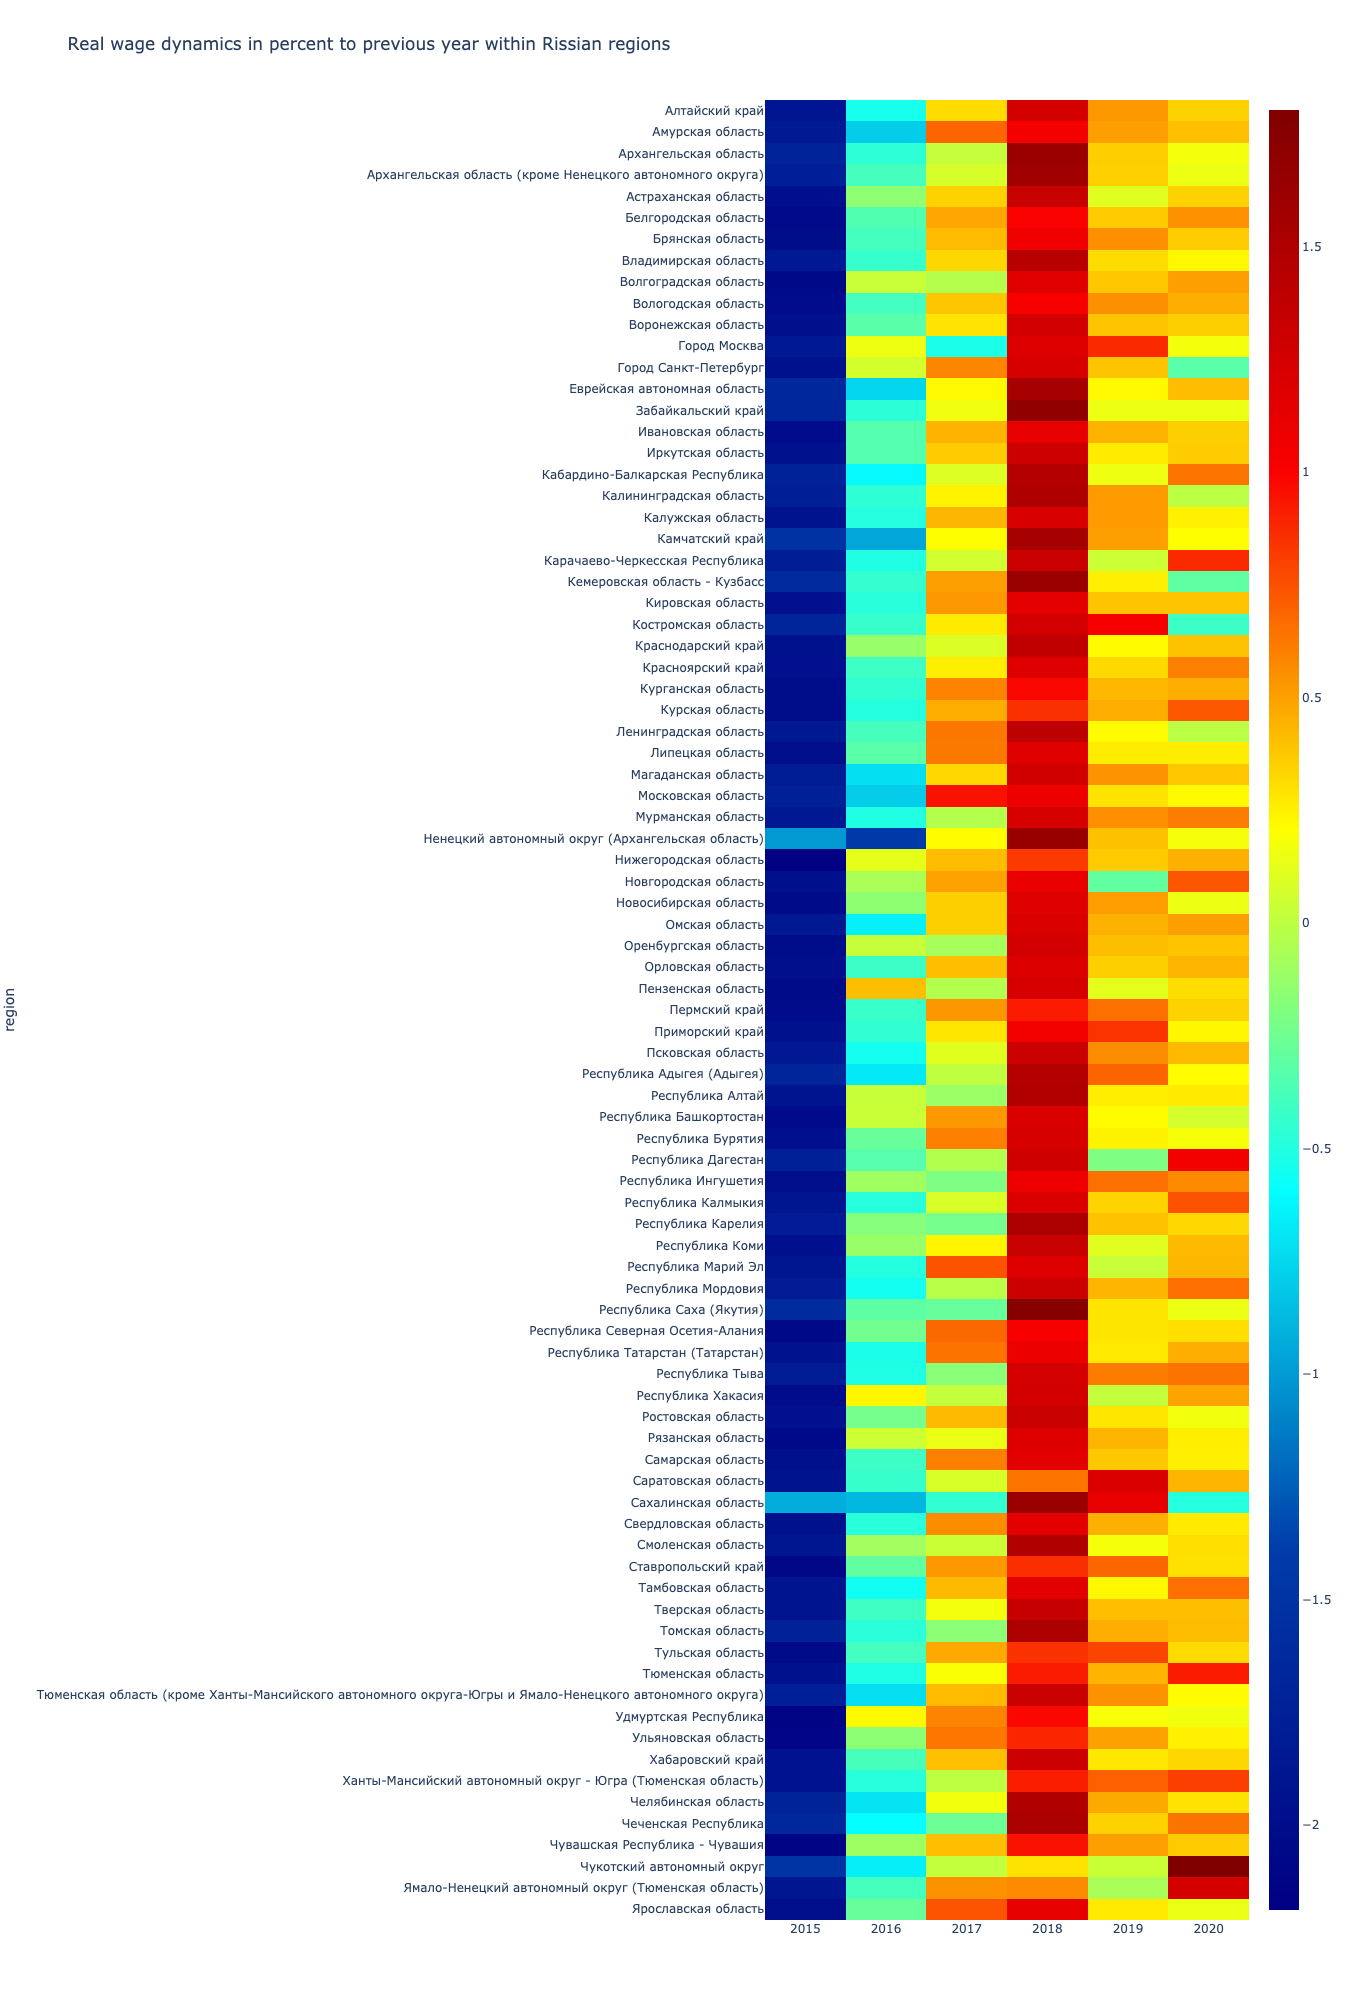

In [ ]:
# Delete the years which have up to 40 % of empty values.
data_real_wage = drop_empty_years(data_real_wage)

data_real_wage_normalized = normalize_data(data_real_wage)

fig = px.imshow(
    data_real_wage_normalized,
    height=2000,
    width=1350,
    color_continuous_scale='Jet',
    title='Real wage dynamics in percent to previous year within Rissian regions'
)
fig.show('png')

Some of the regions show lower real wage gynamics in percent compared to the previous year. These are:
- Город Санкт-Петербург
- Калининградская область
- Кемеровская область - Кузбасс
- Костромская область
- Ленинградская область
- Республика Башкортостан
- Сахалинская область

These regions are more likely to have weaker economic devlopment compared to the other regions.

### 2.14 Intermediate conclusions

I have aggregated the number of occurrence of different regions in the negative statistics above and came to the following values:
- Республика Ингушетия: 6
- Республика Тыва: 5
- Карачаево-Черкесская Республика 4
- Ненецкий автономный округ (Архангельская область): 4
- Ханты-Мансийский автономный округ - Югра (Тюменская область): 4
- Чеченская Республика: 4
- Город Санкт-Петербург: 3
- Республика Коми: 3
- Сахалинская область: 3
- Томская область: 3

Thus after applying the custer algorithms I expect the cluster containing most of these regions to be the cluster of economically weak regions.

### 2.15 Final data preparation

#### 2.15.1 Rename the columns

Raname the columns to reflect the data source.

Some of the columns have been already renamed above, where it was necessary to include the data type per year, e.g. `poverty_dem_adults_2017`.

In [ ]:
data_population_normalized = rename_columns(
    data_population_normalized, 
    'population_', 
    start_col=0
)
data_child_mortality_rural_normalized = rename_columns(
    data_child_mortality_rural_normalized, 
    'child_mortality_rural_', 
    start_col=0
)
data_child_mortality_urban_normalized = rename_columns(
    data_child_mortality_urban_normalized, 
    'child_mortality_urban_', 
    start_col=0
)
data_welfare_share_normalized = rename_columns(
    data_welfare_share_normalized, 
    'welfare_share_',
    start_col=0
)
data_gross_product_normalized = rename_columns(
    data_gross_product_normalized, 
    'gross_product_',
    start_col=0
)
data_production_normalized = rename_columns(
    data_production_normalized, 
    'production_',
    start_col=0
)
data_retail_turnover_normalized = rename_columns(
    data_retail_turnover_normalized, 
    'retail_turnover_',
    start_col=0
)
data_monthly_cash_income_normalized = rename_columns(
    data_monthly_cash_income_normalized, 
    'monthly_income_',
    start_col=0
)
data_real_cash_income_normalized = rename_columns(
    data_real_cash_income_normalized, 
    'real_income_',
    start_col=0
)
data_monthly_formal_wage_normalized = rename_columns(
    data_monthly_formal_wage_normalized, 
    'monthly_wage_',
    start_col=0
)
data_real_wage_normalized = rename_columns(
    data_real_wage_normalized, 
    'real_wage_',
    start_col=0
)

real_wage_2015  \
region                                                               
Алтайский край                                           -1.910288   
Амурская область                                         -1.840622   
Архангельская область                                    -1.720154   
Архангельская область (кроме Ненецкого автономн...       -1.783510   
Астраханская область                                     -1.985447   
...                                                            ...   
Чеченская Республика                                     -1.656650   
Чувашская Республика - Чувашия                           -2.128059   
Чукотский автономный округ                               -1.493211   
Ямало-Ненецкий автономный округ (Тюменская обла...       -1.912056   
Ярославская область                                      -2.001667   

                                                    real_wage_2016  \
region                                                               
Алтайский край                                           -0.534881   
Амурская область                                         -0.797530   
Архангельская область                                    -0.465160   
Архангельская область (кроме Ненецкого автономн...       -0.383716   
Астраханская область                                     -0.149042   
...                                                            ...   
Чеченская Республика                                     -0.594259   
Чувашская Республика - Чувашия                           -0.104844   
Чукотский автономный округ                               -0.657632   
Ямало-Ненецкий автономный округ (Тюменская обла...       -0.386964   
Ярославская область                                      -0.283194   

                                                    real_wage_2017  \
region                                                               
Алтайский край                                            0.316562   
Амурская область                                          0.688875   
Архангельская область                                     0.021853   
Архангельская область (кроме Ненецкого автономн...        0.076743   
Астраханская область                                      0.345989   
...                                                            ...   
Чеченская Республика                                     -0.259534   
Чувашская Республика - Чувашия                            0.405210   
Чукотский автономный округ                                0.015474   
Ямало-Ненецкий автономный округ (Тюменская обла...        0.546302   
Ярославская область                                       0.740166   

                                                    real_wage_2018  \
region                                                               
Алтайский край                                            1.249874   
Амурская область                                          1.040918   
Архангельская область                                     1.632741   
Архангельская область (кроме Ненецкого автономн...        1.587047   
Астраханская область                                      1.336052   
...                                                            ...   
Чеченская Республика                                      1.515968   
Чувашская Республика - Чувашия                            0.949268   
Чукотский автономный округ                                0.294000   
Ямало-Ненецкий автономный округ (Тюменская обла...        0.569064   
Ярославская область                                       1.126340   

                                                    real_wage_2019  \
region                                                               
Алтайский край                                            0.529423   
Амурская область                                          0.506334   
Архангельская область                                     0.359016   
Архангельская область (кроме Ненецкого автономн...        

#### 2.15.2 Concatenate data sources

Concatenate data from all data sources into a single dataset.

In [ ]:
dataframes = [
    data_population_normalized, data_child_mortality_rural_normalized,
    data_child_mortality_urban_normalized, data_disability_normalized,
    data_desease_incidence_normalized, data_welfare_share_normalized,
    data_poverty_normalized, data_poverty_dem_normalized, data_housing_size_normalized,
    data_housing_state_normalized, data_gross_product_normalized, data_production_normalized,
    data_retail_turnover_normalized, data_monthly_cash_income_normalized,
    data_real_cash_income_normalized, data_monthly_formal_wage_normalized,
    data_real_wage_normalized
]

X = pd.concat(dataframes, axis=1)

In [ ]:
kmeans = KMeans(
    n_clusters=2, init='k-means++', n_init=2, max_iter=100, random_state=42
)
kmeans.fit(X)
labels = kmeans.labels_
score = silhouette_score(X, labels)
print(f"Silhouette Score: {score:.3f}")

ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values